# Revisiting the Zillow Data

In [1]:
%matplotlib inline
from env import get_connection, password, host, user
import acquire_zillow
import acquire_mall
import prepare_mall
import prepare_zillow
import explore_zillow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import ttest_ind, chi2_contingency, pearsonr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import f_regression, RFE
from sklearn.preprocessing import MinMaxScaler

In [2]:
properties = pd.read_csv('zillow_properties.csv', sep='\t')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
properties.drop(['Unnamed: 0', 'parcelid.1'], axis=1, inplace=True)

In [4]:
properties.shape

(167888, 60)

In [5]:
properties[['fips', 'regionidcounty']].head(10)

,fips,regionidcounty
0,6037.0,3101.0
1,6059.0,1286.0
2,6037.0,3101.0
3,6037.0,3101.0
4,6059.0,1286.0
5,6037.0,3101.0
6,6037.0,3101.0
7,6111.0,2061.0
8,6059.0,1286.0
9,6059.0,1286.0


## Preparation Phase

### Filling nulls with zeros. These variables were chosen because they either are binary and just didn't have 0's, or they are some type of cnt that was left blank since it was 0.

In [6]:
properties = prepare_zillow.replace_nulls_with_zeros(properties, ['hashottuborspa', 'poolcnt', 'poolsizesum', 
                                                                  'basementsqft', 'decktypeid', 'fireplacecnt',
                                                                  'garagecarcnt'])

### Before filtering for single unit properties, I will impute the unit count where it is missing since some counties have that field as mostly NaN's. Unit count will be imputed as NaN when land use description is 'Single Family Residential'.

In [7]:
properties.loc[((properties.regionidcounty == 1286) | (properties.regionidcounty == 2061)) & 
               (properties.propertylandusedesc == 'Single Family Residential'), 
               'unitcnt'] = 1

### Grabbing only those properties that are single unit and have lat and lon. 
The columns that are transformed to object dtypes are chosen because they either are just simple id numbers or a binary representing yes or no.

In [8]:
properties = prepare_zillow.single_lat_lon_objects(properties, ['parcelid', 'buildingqualitytypeid', 
                                                                'decktypeid', 'fips', 'hashottuborspa', 
                                                                'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 
                                                                'regionidcity', 'regionidcounty',
                                                                'regionidneighborhood', 'regionidzip', 
                                                                'fireplaceflag', 'censustractandblock', 
                                                                'assessmentyear'])


In [9]:
prepare_zillow.missing_vals_cols(properties)

buildingqualitytypeid has 40865 missing values, accounting for 29.71% of that column.
calculatedbathnbr has 67 missing values, accounting for 0.05% of that column.
finishedfloor1squarefeet has 128204 missing values, accounting for 93.22% of that column.
calculatedfinishedsquarefeet has 16 missing values, accounting for 0.01% of that column.
finishedsquarefeet12 has 346 missing values, accounting for 0.25% of that column.
finishedsquarefeet13 has 137529 missing values, accounting for 100.00% of that column.
finishedsquarefeet15 has 137518 missing values, accounting for 99.99% of that column.
finishedsquarefeet50 has 128204 missing values, accounting for 93.22% of that column.
finishedsquarefeet6 has 137210 missing values, accounting for 99.77% of that column.
fullbathcnt has 67 missing values, accounting for 0.05% of that column.
garagetotalsqft has 98562 missing values, accounting for 71.67% of that column.
lotsizesquarefeet has 2639 missing values, accounting for 1.92% of that column.

### Do any columns have too many NaN's to be useful?
After looking at the print out and seeing which columns have what percentage of null values, I decide that if a column is more than 30% null, it should be dropped.

In [10]:
prepare_zillow.drop_col_if_too_many_nulls(properties, .25)

Nulls still present but not nearly as many.

In [11]:
prepare_zillow.missing_vals_cols(properties)

calculatedbathnbr has 67 missing values, accounting for 0.05% of that column.
calculatedfinishedsquarefeet has 16 missing values, accounting for 0.01% of that column.
finishedsquarefeet12 has 346 missing values, accounting for 0.25% of that column.
fullbathcnt has 67 missing values, accounting for 0.05% of that column.
lotsizesquarefeet has 2639 missing values, accounting for 1.92% of that column.
regionidcity has 2741 missing values, accounting for 1.99% of that column.
regionidzip has 34 missing values, accounting for 0.02% of that column.
yearbuilt has 77 missing values, accounting for 0.06% of that column.
structuretaxvaluedollarcnt has 133 missing values, accounting for 0.10% of that column.
taxvaluedollarcnt has 2 missing values, accounting for 0.00% of that column.
landtaxvaluedollarcnt has 2 missing values, accounting for 0.00% of that column.
taxamount has 9 missing values, accounting for 0.01% of that column.
censustractandblock has 293 missing values, accounting for 0.21% of

In [12]:
properties.shape

(137529, 35)

### Dropping the rows with remaining null values.

In [13]:
properties.dropna(inplace=True)

In [14]:
properties.shape

(131633, 35)

In [15]:
properties.isna().sum()

parcelid                        0
basementsqft                    0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
decktypeid                      0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fireplacecnt                    0
fullbathcnt                     0
garagecarcnt                    0
hashottuborspa                  0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
poolsizesum                     0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedo

In [16]:
properties[properties.calculatedfinishedsquarefeet != properties.finishedsquarefeet12]

,parcelid,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc


In [17]:
properties[properties.calculatedbathnbr != properties.bathroomcnt]

,parcelid,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,decktypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc


##### Dropping `finishedsquarefeet12` since it's values are the same as `calculatedfinishedsquarefeet`. Same with `calculatedbathnbr` and `bathroomcnt`.

In [18]:
properties.drop(['finishedsquarefeet12', 'calculatedbathnbr'], axis=1, inplace=True)

##### Dropping `fullbathcnt` since it is similar to `bathroomcnt`.

In [19]:
properties.drop(['fullbathcnt'], axis=1, inplace=True)

##### I don't think land use code will be a factor in estimate error.
It will be dropped.

In [20]:
properties.propertycountylandusecode.unique()

array(['0100', '010C', '122', '010E', '0104', '0101', '1', '0700', '1111',
       '01DC', '1110', '012C', '010G', '01HC', '0103', '0111', '010M',
       '0108', '0109', '010H', '010V', '0102', '0110', '0130', '0114',
       '070D', '012E', '010', '0131', '0113', '0133', '0105', '1112',
       '012D'], dtype=object)

In [21]:
properties.drop(['propertycountylandusecode'], axis=1, inplace=True)

##### Dropping `roomcnt` since it's values don't make sense.

In [22]:
properties.drop(['roomcnt'], axis=1, inplace=True)

In [23]:
properties.shape

(131633, 30)

##### Dropping `basementsqft`, `decktypeid`, `poolsizesum`, and `fireplacecnt`  since the values are all 0.

In [24]:
properties.drop(['basementsqft', 'decktypeid', 'fireplacecnt', 'poolsizesum'], axis=1, inplace=True)

##### Dropping `unitcnt`, `fips`, and `regionidcounty` since those columns have only one value for all instances.

In [25]:
properties.drop(['unitcnt', 'fips', 'regionidzip', 'regionidcity'], axis=1, inplace=True)

In [26]:
properties.regionidcounty.unique()

array([3101.0, 1286.0, 2061.0], dtype=object)

##### Dropping `rawcensustractandblock`  since it is the same as `censustractandblock`.

In [27]:
properties.drop(['rawcensustractandblock'], axis=1, inplace=True)

##### Dropping transaction date, census tract,  and assessment year.

In [28]:
properties.drop(['transactiondate', 'assessmentyear', 'censustractandblock'], axis=1, inplace=True)

##### Are the descriptions useful? Example: `airconditioningdesc` can be centralized or refrigeration, but can also just be 'yes'.
Seeing that properties can have 'presumably' no air conditioning but still have a bed or bath, it seems like this column may not be useful.

In [29]:
# properties[(properties.airconditioningdesc.isna()) & ((properties.bathroomcnt > 0) | (properties.bedroomcnt > 0))].describe()

# Outliers kept in for now

### Handling of Outliers
Outliers will be determined using IQR, specifically by looking for values that are over the Q3 point by 1.5 (IQR) or those that are under the Q1 point by 1.5 (IQR). I will be using my `detect_and_remove_outliers()` to do so. I will be handling some columns differently. For bedroom and bathroom counts, any outliers will be grouped into those with more than x amount.

In [30]:
# prepare_zillow.detect_and_remove_outliers(properties)

In [31]:
properties.shape

(131633, 18)

In [32]:
properties.bedroomcnt.describe()

count    131633.000000
mean          3.099899
std           0.999781
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          16.000000
Name: bedroomcnt, dtype: float64

In [33]:
properties.bedroomcnt.value_counts()

3.0     55148
4.0     32493
2.0     29401
5.0      7938
1.0      4732
6.0      1218
0.0       417
7.0       219
8.0        47
9.0        15
10.0        3
11.0        1
16.0        1
Name: bedroomcnt, dtype: int64

##### If a property has more than 6 bedrooms, it will just be listed as having 6.

In [34]:
properties.loc[properties.bedroomcnt > 6, 'bedroomcnt'] = 6
properties.bedroomcnt.describe()

count    131633.000000
mean          3.096974
std           0.988512
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: bedroomcnt, dtype: float64

In [35]:
properties.bathroomcnt.value_counts()

2.0     56618
3.0     29773
1.0     24003
2.5      8514
4.0      4661
3.5      1784
1.5      1757
5.0      1595
4.5      1414
6.0       581
5.5       464
7.0       194
6.5        95
8.0        94
9.0        36
7.5        25
10.0       14
11.0        5
8.5         3
13.0        1
20.0        1
15.0        1
Name: bathroomcnt, dtype: int64

##### If a property has more than 4 bathrooms, it will just be listed as having 4.

In [36]:
properties.loc[properties.bathroomcnt > 4, 'bathroomcnt'] = 4
properties.bathroomcnt.describe()

count    131633.000000
mean          2.229369
std           0.827650
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: bathroomcnt, dtype: float64

##### Changing hot tub or spa to a float

In [37]:
properties['hashottuborspa'] = properties.hashottuborspa.astype(float)

## Exploration Phase

##### Making a new column to indicate if a property has a hot tub or spa.

In [38]:
#properties['has_hottub_or_spa'] = properties.hashottuborspa

In [39]:
#properties.loc[properties.has_hottub_or_spa == 1, 'has_hottub_or_spa'] = 'yes'

In [40]:
#properties.loc[properties.has_hottub_or_spa == 0, 'has_hottub_or_spa'] = 'no'

In [41]:
#properties.has_hottub_or_spa.unique()

In [42]:
#properties.drop(['hashottuborspa'], axis=1, inplace=True)

##### Making a new column to indicate if a property has a pool or not.

In [43]:
#properties.poolcnt.unique()

In [44]:
#properties['has_pool'] = properties.poolcnt

In [45]:
#properties.loc[properties.has_pool == 1, 'has_pool'] = 'yes'
#properties.loc[properties.has_pool == 0, 'has_pool'] = 'no'

In [46]:
#properties.has_pool.unique()

In [47]:
#properties.drop(['poolcnt'], axis=1, inplace=True)

##### Plotting a pairplot and a heatmap of all ordered numeric variables.

In [48]:
properties.dtypes

parcelid                         object
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
regionidcounty                   object
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
landtaxvaluedollarcnt           float64
taxamount                       float64
logerror                        float64
propertylandusedesc              object
dtype: object

In [49]:
# sns.pairplot(properties[['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 
#                     'taxamount']])

##### Dropping `landtaxvaluedollarcnt` and `taxvaluedollarcnt` since it has such a hogh correlation with `taxamount`.

In [50]:
properties.drop(['landtaxvaluedollarcnt', 'taxvaluedollarcnt'], axis=1, inplace=True)

<Figure size 1440x1440 with 0 Axes>

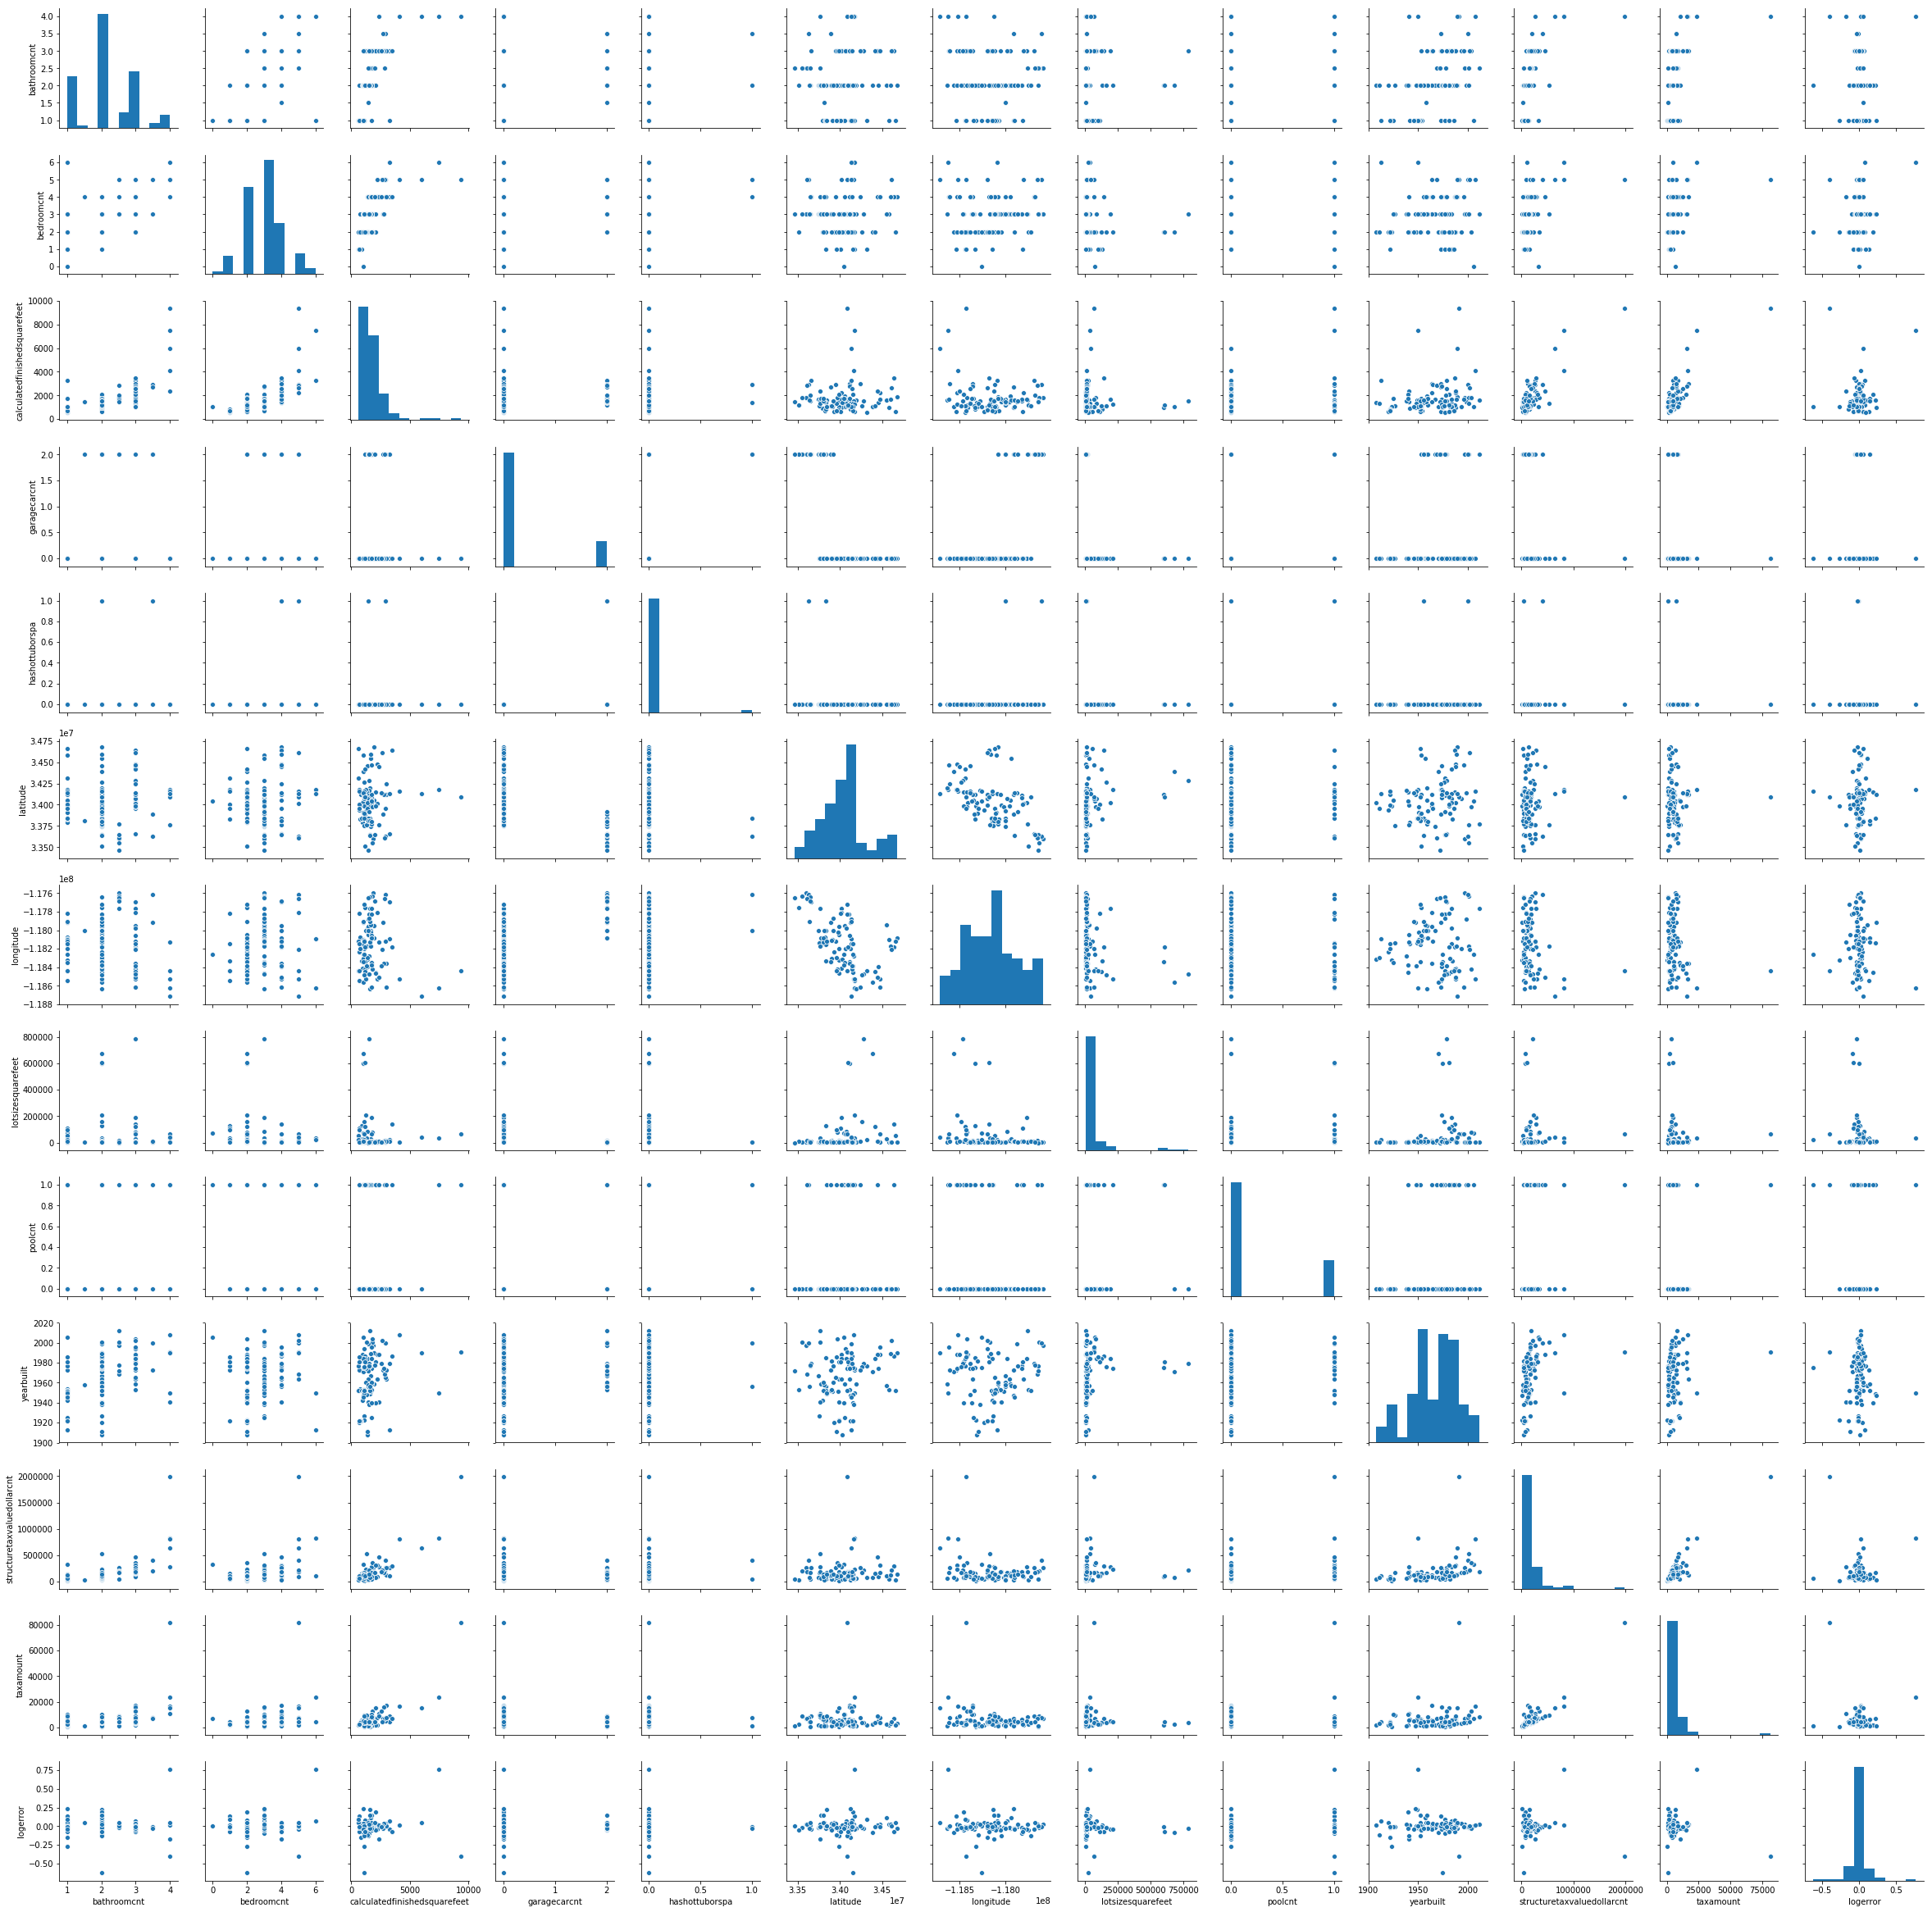

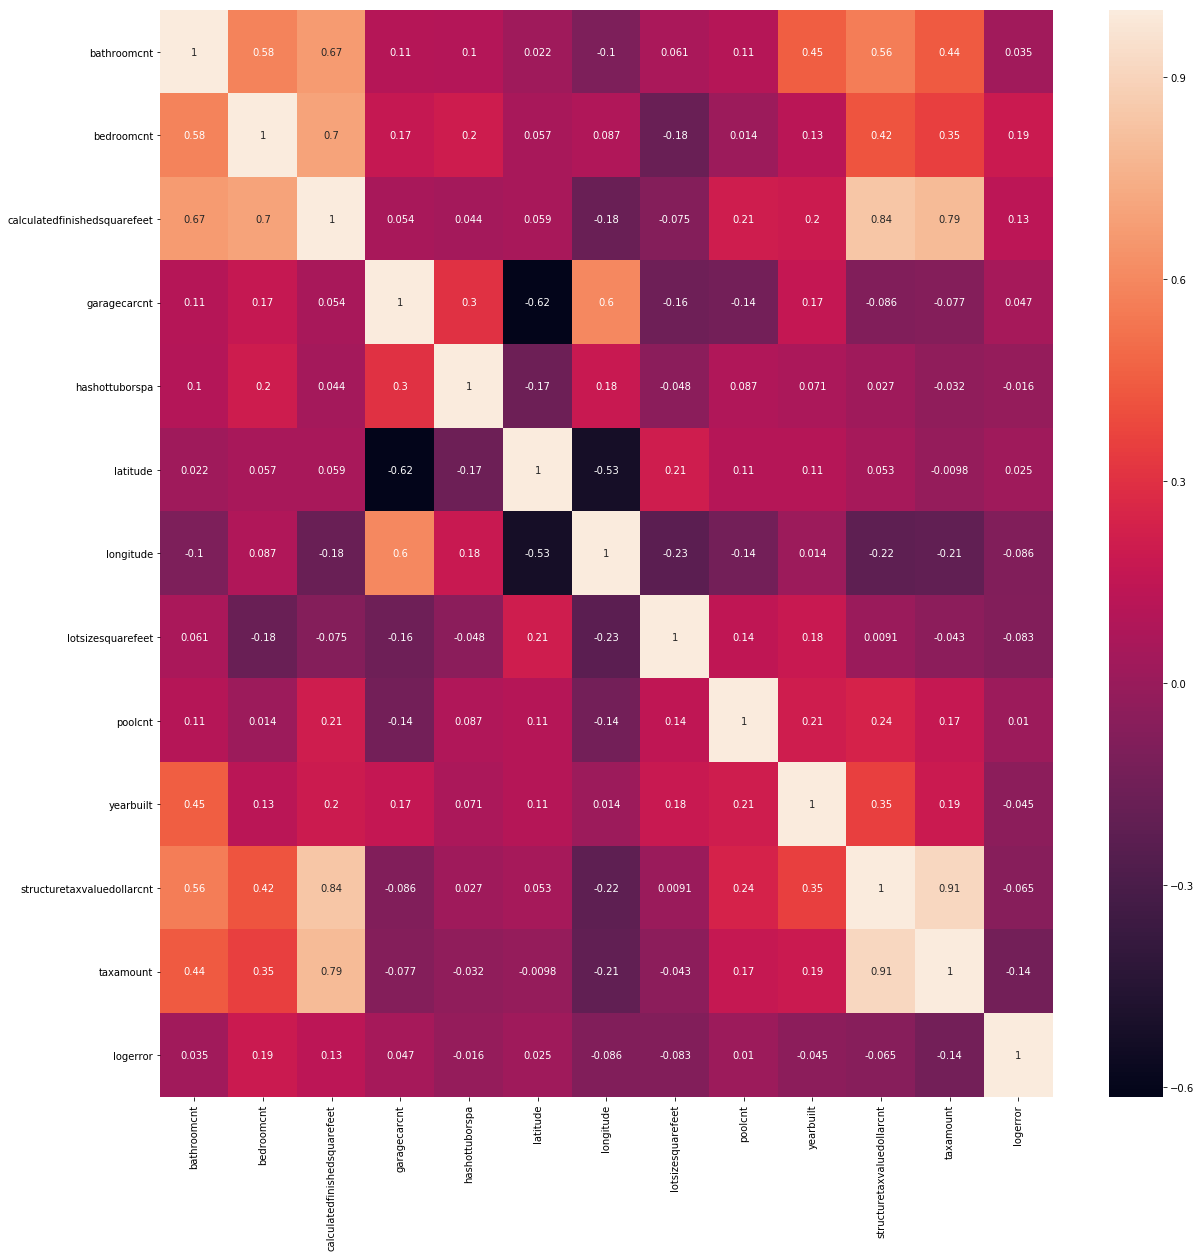

In [51]:
explore_zillow.pair_heat_(properties.select_dtypes('number').sample(100))

##### Plotting a relplot of two ordered numerical variables and one categorical variable.

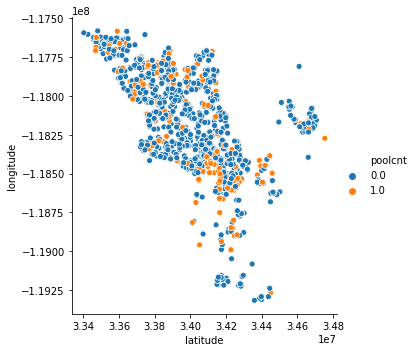

In [52]:
explore_zillow.relplot_TwoNum_OneCat(properties.sample(1000), 'latitude', 'longitude', 'poolcnt')

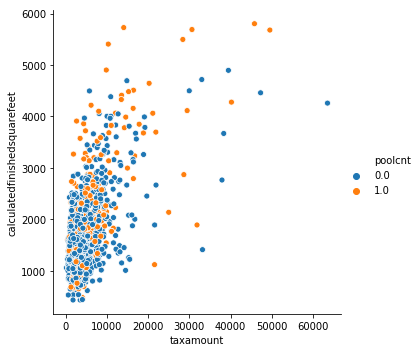

In [53]:
explore_zillow.relplot_TwoNum_OneCat(properties.sample(1000), 'taxamount', 'calculatedfinishedsquarefeet', 'poolcnt')

In [54]:
properties[['taxamount', 'calculatedfinishedsquarefeet']].describe()

,taxamount,calculatedfinishedsquarefeet
count,131633.000000,131633.000000
mean,6053.899127,1793.134556
std,7416.322926,939.354350
min,49.080000,2.000000
25%,2744.910000,1200.000000
50%,4494.370000,1554.000000
75%,6923.160000,2126.000000
max,321936.090000,21929.000000


##### Plotting subplots of swarmplots for a categorical variable and listed numerical variables.

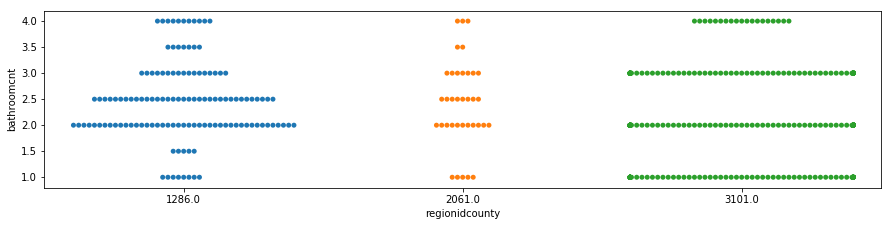

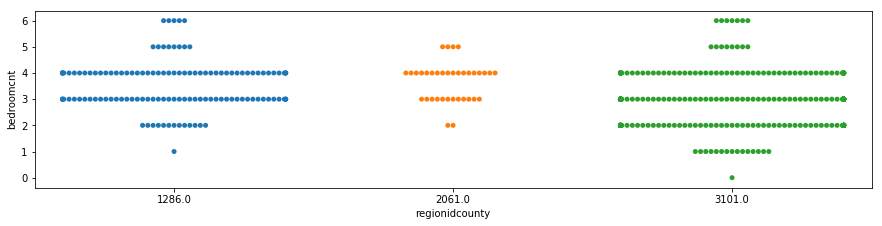

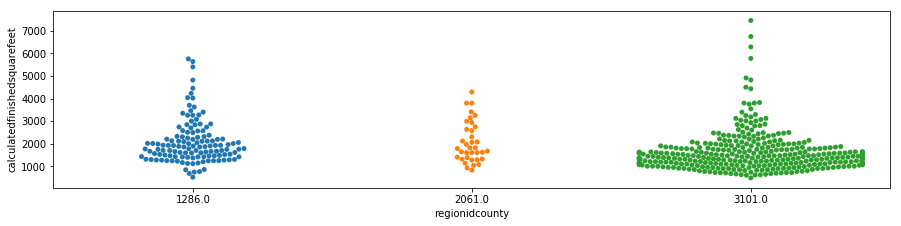

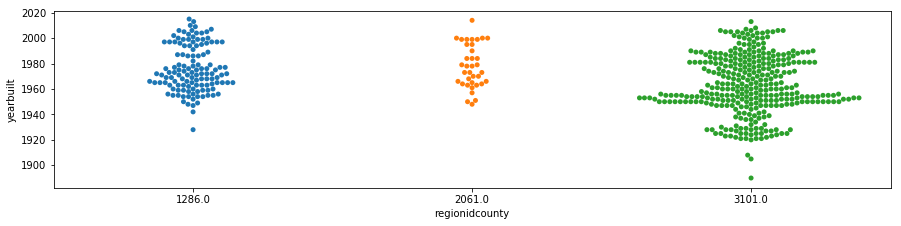

In [55]:
explore_zillow.swarm_subs(properties.sample(500), 'regionidcounty', 
                          ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt'])

##### Plotting distributions of categorical variables

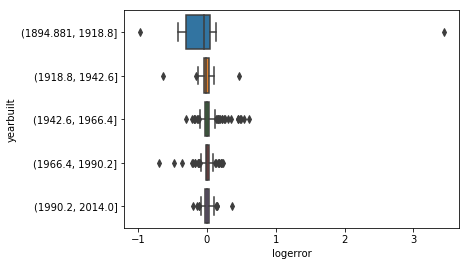

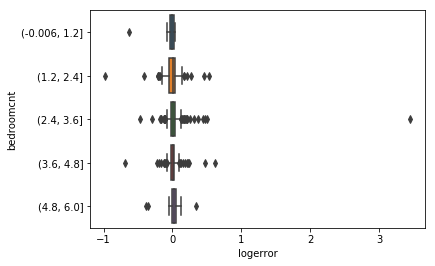

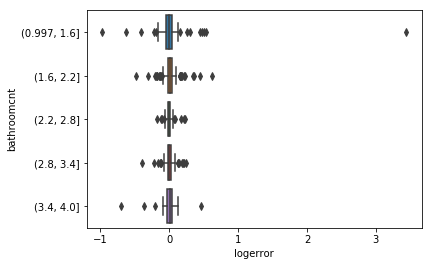

In [56]:
explore_zillow.cat_boxplots(properties.sample(500), ['yearbuilt', 'bedroomcnt', 'bathroomcnt'], 'logerror')

### Performing ttests to check for differences in logerror between groups.

In [57]:
a = properties[properties.bathroomcnt < 3]
b = properties[properties.bathroomcnt >= 3]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 1.0227181731874986e-20
There is a significant difference.


In [58]:
properties.groupby('bathroomcnt')['logerror'].mean()

bathroomcnt
1.0    0.010764
1.5    0.014523
2.0    0.012039
2.5    0.013147
3.0    0.016307
3.5    0.029843
4.0    0.033874
Name: logerror, dtype: float64

In [59]:
properties.groupby('bathroomcnt')['logerror'].std()

bathroomcnt
1.0    0.187594
1.5    0.140001
2.0    0.150238
2.5    0.151091
3.0    0.144230
3.5    0.190383
4.0    0.210853
Name: logerror, dtype: float64

In [60]:
a = properties[properties.poolcnt == 1]
b = properties[properties.poolcnt == 0]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 1.28565251086006e-06
There is a significant difference.


In [61]:
properties.groupby('poolcnt')['logerror'].mean()

poolcnt
0.0    0.015851
1.0    0.010786
Name: logerror, dtype: float64

In [62]:
a = properties[properties.yearbuilt < 1950]
b = properties[properties.yearbuilt >= 1950]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 6.931925175851679e-13
There is a significant difference.


In [63]:
a = properties[properties.regionidcounty == 3101]
b = properties[properties.regionidcounty == 1286]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 1.1444799562082161e-08
There is a significant difference.


In [64]:
properties.groupby('regionidcounty')['logerror'].mean()

regionidcounty
1286.0    0.019226
2061.0    0.016225
3101.0    0.013034
Name: logerror, dtype: float64

In [65]:
properties.groupby('regionidcounty')['logerror'].std()

regionidcounty
1286.0    0.164742
2061.0    0.157248
3101.0    0.161351
Name: logerror, dtype: float64

### Chi Squared Testing

In [66]:
explore_zillow.print_chi_test_results(properties.logerror, properties.bathroomcnt)

Category 1 was binned. Here are the bins [-4.65542037764, -0.0253, 0.006, 0.0392, 5.2629986498]
The p-value is: 0.0
There is a relationship between the variables.


In [67]:
explore_zillow.print_chi_test_results(properties.logerror, properties.bedroomcnt)

Category 1 was binned. Here are the bins [-4.65542037764, -0.0253, 0.006, 0.0392, 5.2629986498]
The p-value is: 9.368003183403795e-212
There is a relationship between the variables.


In [68]:
columns = properties.columns
for col in columns:
    print(col)
    print(properties[col].unique())
    print('\n')

parcelid
[11016594 12098116 12643413 ... 17239384 12773139 12826780]


bathroomcnt
[2.  3.  2.5 4.  1.  1.5 3.5]


bedroomcnt
[3. 2. 4. 5. 1. 6. 0.]


calculatedfinishedsquarefeet
[1684. 2217.  839. ... 4230. 4921. 5655.]


garagecarcnt
[ 0.  2.  3.  1.  4.  6.  8.  5.  7. 11. 10. 24.  9. 13. 14.]


hashottuborspa
[0. 1.]


latitude
[34280990. 34136312. 33755800. ... 33870815. 34245368. 34300140.]


longitude
[-1.18488536e+08 -1.18175032e+08 -1.18309000e+08 ... -1.18706327e+08
 -1.18038169e+08 -1.17996709e+08]


lotsizesquarefeet
[ 7528. 11423. 70859. ... 25568. 45398. 47405.]


poolcnt
[0. 1.]


regionidcounty
[3101.0 1286.0 2061.0]


yearbuilt
[1959. 1940. 1987. 1981. 1982. 1939. 1954. 1995. 1944. 1955. 1964. 1970.
 1957. 1950. 1927. 1976. 1962. 1952. 1998. 1986. 1966. 1983. 1961. 1953.
 1948. 1979. 1946. 1965. 1972. 1956. 1912. 2005. 1980. 1947. 1988. 1968.
 1994. 1989. 1923. 1974. 1963. 1960. 1951. 1978. 1975. 1928. 2003. 1990.
 1993. 1973. 1913. 1925. 1949. 1977. 1926. 1938. 1999.

In [69]:
properties.shape

(131633, 16)

## Clustering Logerror to Use as a Potential Variable.
We will use logerror as the sole variable to identify clusters. By doing so, we can see if there are different groupings within logerror. Afterwards, we can use these groupings as a variable.

In [70]:
X = properties[['logerror']]

##### Determining the best number of clusters using the elbow method.

In [71]:
# intertias = []
# for n in range(1, 16):
#     kmeans = KMeans(n_clusters=n, random_state=123)
#     kmeans.fit(X)
#     intertias.append(kmeans.inertia_)
    
# kmeans_perf = pd.DataFrame(list(zip(range(1, 16), intertias)), columns=['n_clusters', 'ssd'])

In [72]:
# plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
# plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

# plt.xticks(range(1, 16))
# plt.xlabel('Number of Clusters')
# plt.ylabel('Sum of Squared Distances')
# plt.title('The elbow method')

In [73]:
kmeans2 = KMeans(n_clusters=5, random_state=123)
kmeans2.fit(X)
properties['cluster_target'] = kmeans2.predict(X)

centers = kmeans2.cluster_centers_
inertia = kmeans2.inertia_

print(centers)
print(inertia)

[[ 0.01839458]
 [ 0.36436958]
 [ 1.88821002]
 [-0.12986307]
 [-1.09903459]]
857.1201885813667


In [74]:
a = list(zip(centers, centers))

In [75]:
e = pd.DataFrame(a, columns=['x', 'y'])

<Figure size 1080x1080 with 0 Axes>

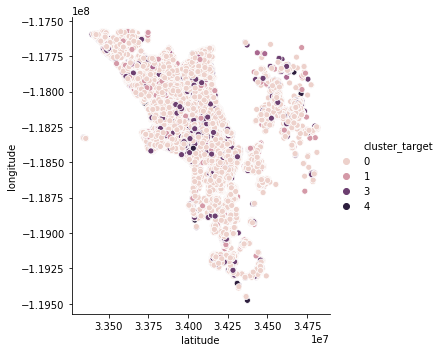

In [76]:
plt.figure(figsize=(15,15))
sns.relplot(data=properties, x='latitude', y='longitude', hue='cluster_target')

(-1.5, 2)

<Figure size 1080x1080 with 0 Axes>

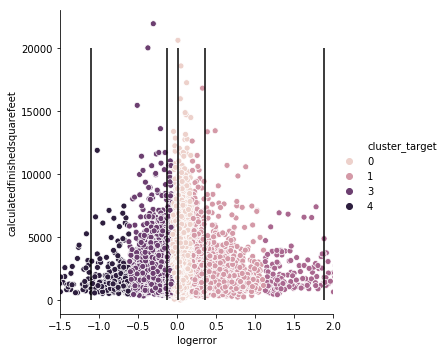

In [77]:
plt.figure(figsize=(15,15))
sns.relplot(data=properties, x='logerror', y='calculatedfinishedsquarefeet', hue='cluster_target')
# plt.scatter(e.x, e.y, marker='X', s=300, c='black')
plt.vlines(x=e.x, ymin=0, ymax=20000)
plt.xlim(left=-1.5, right=2)

In [78]:
properties.groupby('cluster_target')['logerror'].mean()

cluster_target
0    0.018424
1    0.364499
2    1.888210
3   -0.129712
4   -1.099035
Name: logerror, dtype: float64

In [79]:
properties.loc[properties.cluster_target == 0, 'cluster_target'] = '1'
properties.loc[properties.cluster_target == 1, 'cluster_target'] = '3'
properties.loc[properties.cluster_target == 2, 'cluster_target'] = '5'
properties.loc[properties.cluster_target == 3, 'cluster_target'] = '2'
properties.loc[properties.cluster_target == 4, 'cluster_target'] = '4'

In [80]:
properties.groupby('cluster_target')['logerror'].mean()

cluster_target
1    0.018424
2   -0.129712
3    0.364499
4   -1.099035
5    1.888210
Name: logerror, dtype: float64

##### Any insight from the clusters?
The clusters can be used to categorize the property as having a smaller logerror or a larger logerror. In our case, the smaller the value of cluster_target, the closer the logerror is to 0 and therefore the better the zestimate was.

### Doing some exploration with our new variable `cluster_target`.

Looking at the clusters that are farthest from having logerror = 0

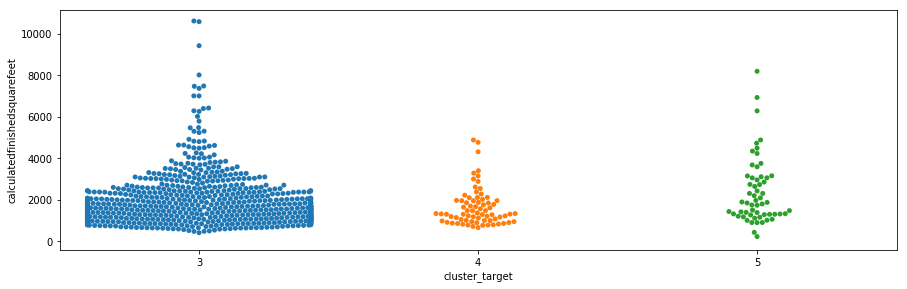

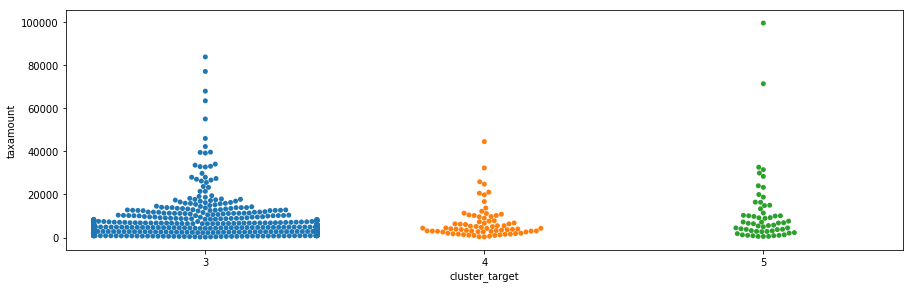

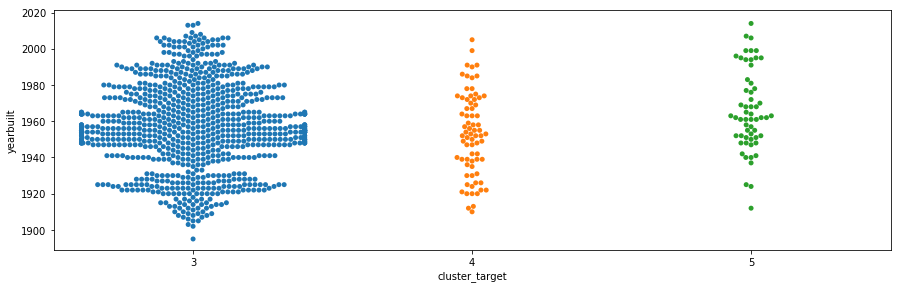

In [81]:
r = properties[(properties.cluster_target == '5') | (properties.cluster_target == '4') | 
               (properties.cluster_target == '3')]

explore_zillow.swarm_subs(r.sample(1000), 'cluster_target', 
                          ['calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt'])

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

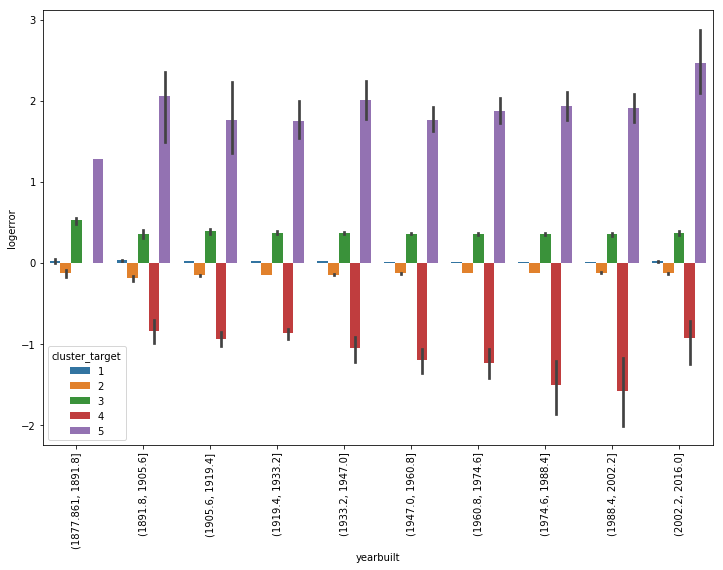

In [82]:
plt.figure(figsize=(12,8))
sns.barplot(data=properties, 
                x=pd.cut(properties.yearbuilt, bins=10, include_lowest=True), 
                y='logerror', 
                hue=properties.cluster_target.astype(int))
plt.xticks(rotation=90)

##### First looking to see if there are differences between groups within variables and the percentage of the properties that have a worse logerror.

In [83]:
a = properties.groupby(['regionidcounty', 'cluster_target']).agg({'regionidcounty': 'sum'})
a.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

regionidcounty
regionidcounty cluster_target                
1286.0         1                    88.140721
               2                     8.150918
               3                     3.201903
               4                     0.203943
               5                     0.302515
2061.0         1                    87.049892
               2                     9.316703
               3                     3.199566
               4                     0.151844
               5                     0.281996
3101.0         1                    80.608218
               2                    14.395707
               3                     4.427215
               4                     0.362393
               5                     0.206467

In [84]:
properties.groupby('regionidcounty')['regionidcounty'].count()

regionidcounty
1286.0    29420
2061.0     9220
3101.0    92993
Name: regionidcounty, dtype: int64

Not really anything stood out.

In [85]:
a = properties.groupby(['bathroomcnt', 'cluster_target']).agg({'bathroomcnt': 'sum'})
a.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

bathroomcnt
bathroomcnt cluster_target             
1.0         1                 75.882181
            2                 17.118693
            3                  5.974253
            4                  0.779069
            5                  0.245803
1.5         1                 87.194081
            2                  8.764940
            3                  3.642573
            4                  0.170746
            5                  0.227661
2.0         1                 82.880003
            2                 12.955244
            3                  3.758522
            4                  0.204882
            5                  0.201349
2.5         1                 91.602067
            2                  6.119333
            3                  1.914494
            4                  0.164435
            5                  0.199671
3.0         1                 85.584254
            2                 10.801733
            3                  3.268062
            4                  0.154502
            5                  0.191449
3.5         1                 86.378924
            2                  9.641256
            3                  3.475336
            5                  0.504484
4.0         1                 80.847125
            2                 12.380226
            3                  5.770906
            4                  0.489983
            5                  0.511760

Again, nothing really stood out.

(array([108917.,      0.,  16644.,      0.,      0.,   5354.,      0.,
           411.,      0.,    307.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

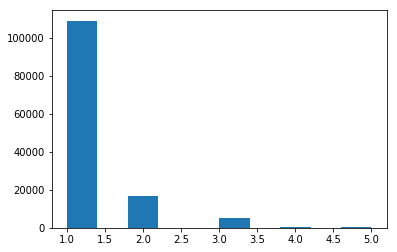

In [86]:
plt.hist(properties.cluster_target.astype(float))

In [87]:
properties.dtypes

parcelid                         object
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
regionidcounty                   object
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxamount                       float64
logerror                        float64
propertylandusedesc              object
cluster_target                   object
dtype: object

In [88]:
explore_zillow.print_chi_test_results(properties.poolcnt, properties.cluster_target)

The p-value is: 1.0866489817679967e-25
There is a relationship between the variables.


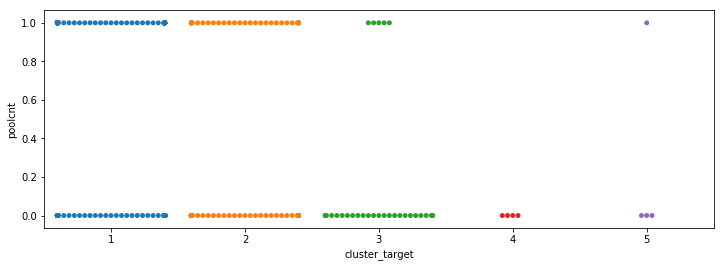

In [89]:
plt.figure(figsize=(12,4))
sns.swarmplot(data=properties.sample(1000), x='cluster_target', y='poolcnt')

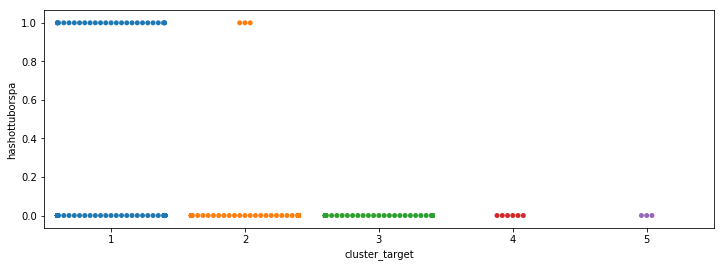

In [90]:
plt.figure(figsize=(12,4))
sns.swarmplot(data=properties.sample(1000), x='cluster_target', y='hashottuborspa')

In [91]:
properties.groupby('cluster_target')['cluster_target'].count()

cluster_target
1    108917
2     16644
3      5354
4       411
5       307
Name: cluster_target, dtype: int64

In [92]:
explore_zillow.print_chi_test_results(properties.cluster_target, properties.yearbuilt)

Category 2 was binned. Here are the bins [1878.0, 1952.0, 1964.0, 1983.0, 2016.0]
The p-value is: 0.0
There is a relationship between the variables.


##### After Doing Some Exploring...
The distribution of logerror clusters is extremely skewed to the right. Majority of logerrors are pretty close to zero. Those that are in the furthest clusters (clusters 4 and 5) only total to 717 properties. Including cluster 3 raises that to over 6000 properties.

The worse clusters tend to be properties that are smaller (less bed and bathrooms and smaller squarefeet relative to the larger homes, but would be still considered common). But is that because the Zestimate doesn't know how to value a smaller home or is that because the smaller properties are more common than huge properties?

Is there a relationship between the clusters and the year built? The chi squared test tells us that yearbuilt and the logerror clusters are not independent of each other, so yes.

### Creating more cluster variables
##### Starting with making a variable for location based on clustering latitude and longitude.

In [93]:
# intertias = []
# for n in range(1, 16):
#     kmeans = KMeans(n_clusters=n, random_state=123)
#     kmeans.fit(properties[['longitude', 'latitude']])
#     intertias.append(kmeans.inertia_)
    
# kmeans_perf = pd.DataFrame(list(zip(range(1, 16), intertias)), columns=['n_clusters', 'ssd'])

In [94]:
# plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
# plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

# plt.xticks(range(1, 16))
# plt.xlabel('Number of Clusters')
# plt.ylabel('Sum of Squared Distances')
# plt.title('The elbow method')

We choose 3 clusters because the elbow method tells us that could be a good number to choose, but also we know there are 3 counties.

In [95]:
kmeans2 = KMeans(n_clusters=3, random_state=123)
kmeans2.fit(properties[['longitude', 'latitude']])
properties['cluster_lat_lon'] = kmeans2.predict(properties[['longitude', 'latitude']])

centers = kmeans2.cluster_centers_
inertia = kmeans2.inertia_

print(centers)
print(inertia)

[[-1.17922220e+08  3.38253230e+07]
 [-1.18335401e+08  3.41613836e+07]
 [-1.18930063e+08  3.42435603e+07]]
8474942273815650.0


In [96]:
e = pd.DataFrame(centers, columns=['lon', 'lat'])
e

,lon,lat
0,-1.179222e+08,3.382532e+07
1,-1.183354e+08,3.416138e+07
2,-1.189301e+08,3.424356e+07


<Figure size 1080x1080 with 0 Axes>

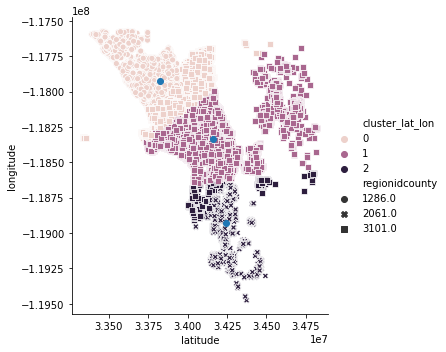

In [97]:
plt.figure(figsize=(15,15))
sns.relplot(data=properties, x='latitude', y='longitude', hue='cluster_lat_lon', style='regionidcounty')
plt.scatter(x=e.lat, y=e.lon)

Cluster 0 corresponds to countyid 1286, cluster 1 is 3101, cluster 2 is 2061.

##### Making a cluster variable based on calculated square feet.

In [98]:
# intertias = []
# for n in range(1, 16):
#     kmeans = KMeans(n_clusters=n, random_state=123)
#     kmeans.fit(properties[['calculatedfinishedsquarefeet']])
#     intertias.append(kmeans.inertia_)
    
# kmeans_perf = pd.DataFrame(list(zip(range(1, 16), intertias)), columns=['n_clusters', 'ssd'])

In [99]:
# plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
# plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

# plt.xticks(range(1, 16))
# plt.xlabel('Number of Clusters')
# plt.ylabel('Sum of Squared Distances')
# plt.title('The elbow method')

In [100]:
kmeans2 = KMeans(n_clusters=4, random_state=123)
kmeans2.fit(properties[['calculatedfinishedsquarefeet']])
properties['cluster_square_feet'] = kmeans2.predict(properties[['calculatedfinishedsquarefeet']])

centers = kmeans2.cluster_centers_
inertia = kmeans2.inertia_

print(centers)
print(inertia)

[[2017.61207389]
 [3277.22817259]
 [1196.0220287 ]
 [6029.46627277]]
17807779095.58235


In [101]:
properties.cluster_square_feet.unique()

array([0, 2, 1, 3])

##### Making a cluster variable based on clustered location and clustered sqft.

In [102]:
# intertias = []
# for n in range(1, 9):
#     kmeans = KMeans(n_clusters=n, random_state=123)
#     kmeans.fit(properties[['cluster_lat_lon', 'cluster_square_feet']])
#     intertias.append(kmeans.inertia_)
    
# kmeans_perf = pd.DataFrame(list(zip(range(1, 9), intertias)), columns=['n_clusters', 'ssd'])

In [103]:
# plt.scatter(kmeans_perf.n_clusters, kmeans_perf.ssd)
# plt.plot(kmeans_perf.n_clusters, kmeans_perf.ssd)

# plt.xticks(range(1, 9))
# plt.xlabel('Number of Clusters')
# plt.ylabel('Sum of Squared Distances')
# plt.title('The elbow method')

In [104]:
kmeans2 = KMeans(n_clusters=4, random_state=123)
kmeans2.fit(properties[['cluster_lat_lon', 'cluster_square_feet']])
properties['cluster_loc_size'] = kmeans2.predict(properties[['cluster_lat_lon', 'cluster_square_feet']])

centers = kmeans2.cluster_centers_
inertia = kmeans2.inertia_

print(centers)
print(inertia)

[[-2.57127653e-13  2.68054425e-01]
 [ 1.09553532e+00  2.02853017e+00]
 [ 1.21069033e+00  2.61441206e-01]
 [-2.97428748e-13  2.02746105e+00]]
22850.818306322704


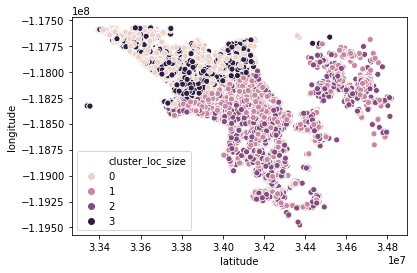

In [105]:
sns.scatterplot(data=properties, x='latitude', y='longitude', hue='cluster_loc_size')

##### Checking significance between logerror clusters.

In [106]:
a = properties[properties.cluster_target == '4']
b = properties[properties.cluster_target == '2']

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 0.0
There is a significant difference.


In [107]:
a = properties[properties.cluster_target == '1']
b = properties[properties.cluster_target == '2']

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 0.0
There is a significant difference.


In [108]:
a = properties[properties.cluster_target == '1']
b = properties[properties.cluster_target == '3']

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 0.0
There is a significant difference.


In [109]:
a = properties[properties.cluster_target == '3']
b = properties[properties.cluster_target == '5']

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 0.0
There is a significant difference.


##### Checking significance between location clusters.

In [110]:
a = properties[properties.cluster_lat_lon == 0]
b = properties[properties.cluster_lat_lon == 1]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 1.4826672817415041e-21
There is a significant difference.


In [111]:
a = properties[properties.cluster_lat_lon == 1]
b = properties[properties.cluster_lat_lon == 2]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 0.00017507527384765764
There is a significant difference.


In [112]:
a = properties[properties.cluster_lat_lon == 0]
b = properties[properties.cluster_lat_lon == 2]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 0.11203695239543501
Not significant.


##### Checking significance between size clusters

In [113]:
a = properties[properties.cluster_square_feet == 0]
b = properties[properties.cluster_square_feet == 1]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 2.5530369628784984e-16
There is a significant difference.


In [114]:
a = properties[properties.cluster_square_feet == 1]
b = properties[properties.cluster_square_feet == 2]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 8.786372416561258e-29
There is a significant difference.


In [115]:
a = properties[properties.cluster_square_feet == 2]
b = properties[properties.cluster_square_feet == 3]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 1.1791033442034783e-25
There is a significant difference.


##### Checking significance between location_size clusters.

In [116]:
a = properties[properties.cluster_loc_size == 0]
b = properties[properties.cluster_loc_size == 1]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 4.7239439033216626e-24
There is a significant difference.


In [117]:
a = properties[properties.cluster_loc_size == 2]
b = properties[properties.cluster_loc_size == 1]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 1.3973504924755295e-08
There is a significant difference.


In [118]:
a = properties[properties.cluster_loc_size == 2]
b = properties[properties.cluster_loc_size == 3]

explore_zillow.print_ttest_results(a.logerror, b.logerror)

The p-value is : 0.07132896101643585
Not significant.


### Making Initial Model
First, split into train and test sets.

In [119]:
properties.drop(['parcelid'], axis=1, inplace=True)

In [120]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(properties.drop(['propertylandusedesc', 'regionidcounty', 
                                                'cluster_target'], axis=1), train_size=.6)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [121]:
print(train.shape)
print(test.shape)

(78979, 16)
(52654, 16)


In [122]:
train.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxamount                       float64
logerror                        float64
cluster_lat_lon                   int32
cluster_square_feet               int32
cluster_loc_size                  int32
dtype: object

In [123]:
explore_zillow.print_chi_test_results(properties.propertylandusedesc, properties.cluster_target)

The p-value is: 7.465669133182242e-36
There is a relationship between the variables.


In [124]:
pd.crosstab(properties.propertylandusedesc, properties.cluster_target, margins=True)

cluster_target,1,2,3,4,5,All
propertylandusedesc,,,,,,
Condominium,19149,2564,647,33,38,22431
Mobile Home,69,15,15,0,1,100
Residential General,18,4,1,0,0,23
Single Family Residential,89678,14061,4691,378,268,109076
Townhouse,3,0,0,0,0,3
All,108917,16644,5354,411,307,131633


In [125]:
train['abs_logerror'] = train.logerror.abs()

In [126]:
train.abs_logerror.describe()

count    78979.000000
mean         0.067854
std          0.147358
min          0.000000
25%          0.013900
50%          0.032500
75%          0.068291
max          5.262999
Name: abs_logerror, dtype: float64

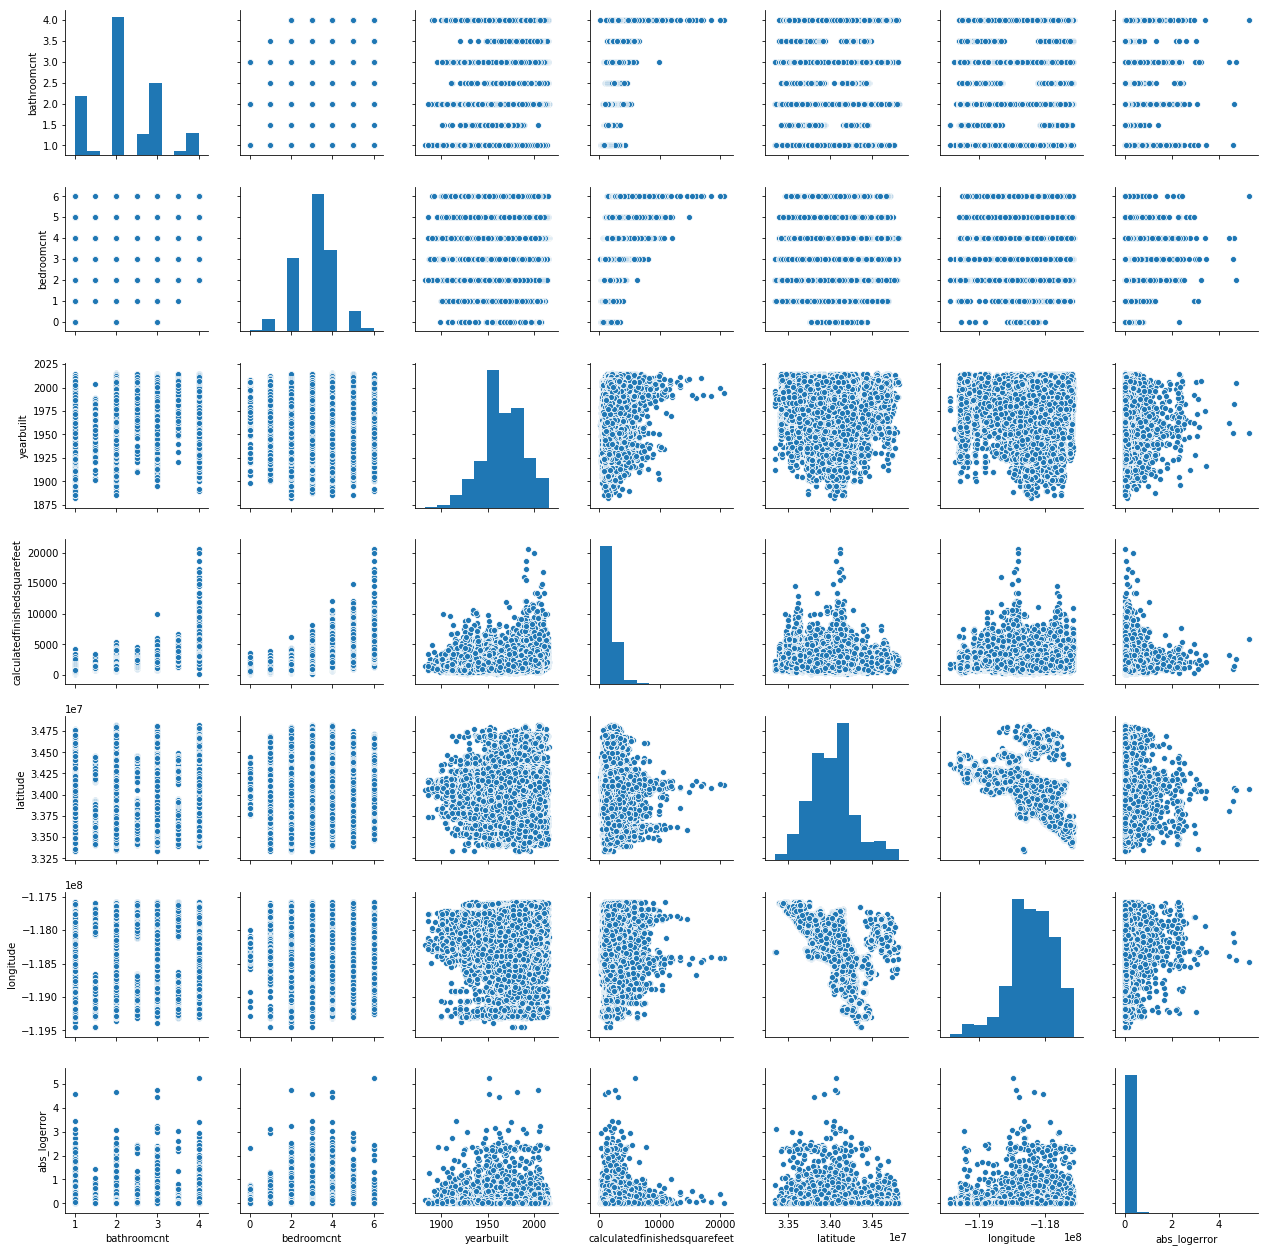

In [127]:
sns.pairplot(train[['bathroomcnt', 'bedroomcnt', 'yearbuilt', 'calculatedfinishedsquarefeet', 'latitude', 
                    'longitude', 'abs_logerror']])

In [128]:
train_x = train.drop(['logerror', 'abs_logerror'], axis=1)

ols = sm.OLS(train[['logerror']], train[['cluster_lat_lon', 'cluster_square_feet', 'yearbuilt', 
                                         'taxamount', 'garagecarcnt']])
ols.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     140.4
Date:                Mon, 15 Apr 2019   Prob (F-statistic):          8.98e-149
Time:                        12:09:32   Log-Likelihood:                 31926.
No. Observations:               78979   AIC:                        -6.384e+04
Df Residuals:                   78974   BIC:                        -6.380e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cluster_lat_lon        -0.0040      0.001     -4.278      0.000      -0.006      -0.002
cluster_square_feet    -0.0009      0.001     -1.421      0.155      -0.002       0.000
yearbuilt            8.995e-06    6.9e-07     13.031      0.000    7.64e-06    1.03e-05
taxamount            -1.04e-07   7.72e-08     -1.347      0.178   -2.55e-07    4.73e-08
garagecarcnt            0.0025      0.001      3.899      0.000       0.001       0.004
==============================================================================
Omnibus:                    77017.742   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         59033861.212
Skew:                           3.836   Prob(JB):                         0.00
Kurtosis:                     136.717   Cond. No.                     1.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
# lm = LinearRegression()
# lm.fit(train[['']], train[['logerror']])
# lm_pred = lm.predict(X)

# r2 = r2_score(y, lm_pred)
# m

### Looking at decision tree model to see how it determines which logerror cluster a property falls into.

In [130]:
from sklearn.tree import DecisionTreeClassifier

In [131]:
a, b = explore_zillow.split_it(properties.drop(['propertylandusedesc', 'regionidcounty',
                                                'logerror'], axis=1), strat=properties[['cluster_target']], training_size=.6)
print(a.shape)
print(b.shape)

Parameters are df, train_size, random_state, and stratify
Returns train, test
(78979, 16)
(52654, 16)


In [132]:
tree = DecisionTreeClassifier(random_state=123, max_depth=3)
tree.fit(a.drop(['cluster_target'], axis=1), 
         a['cluster_target'])
m = tree.predict(a.drop(['cluster_target'], axis=1))

In [133]:
tree.score(a.drop(['cluster_target'], axis=1), a['cluster_target'])

0.8274351409868446

In [134]:
import graphviz
from sklearn.tree import export_graphviz

feature_names = a.drop(['cluster_target'], axis=1).columns
class_names = sorted(a['cluster_target'].unique())

dot = export_graphviz(
    tree,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names, # target value names
    special_characters=True,
    filled=True,             # fill nodes w/ informative colors
    impurity=False,          # show impurity at each node
    leaves_parallel=True,    # all leaves at the bottom
    proportion=True,         # show percentages instead of numbers at each leaf
    rotate=True,             # left to right instead of top-bottom
    rounded=True,            # rounded boxes and sans-serif font
)

graph = graphviz.Source(dot, filename='zillow_decision_tree', format='png')
graph.view(cleanup=True)

'zillow_decision_tree.png'

In [135]:
m = pd.Series(m)

In [136]:
m.describe()

count     78979
unique        1
top           1
freq      78979
dtype: object

In [137]:
a['cluster_target'].describe()

count     78979
unique        5
top           1
freq      65350
Name: cluster_target, dtype: object

In [138]:
65350/78979

0.8274351409868446

In [139]:
z = tree.predict(b.drop(['cluster_target'], axis=1))
tree.score(b.drop(['cluster_target'], axis=1), b['cluster_target'])

0.8274205188589661

In [140]:
b.cluster_target.describe()

count     52654
unique        5
top           1
freq      43567
Name: cluster_target, dtype: object

In [141]:
43567/52654

0.8274205188589661

##### Well that wasn't any help. The decision tree simply categorized everything in cluster 1. Due to the overwhelming majority in cluster 1, it was still 83% accurate. Back to regression modeling.
We'll give Ridge Regression a try.

In [142]:
train.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxamount                       float64
logerror                        float64
cluster_lat_lon                   int32
cluster_square_feet               int32
cluster_loc_size                  int32
abs_logerror                    float64
dtype: object

In [143]:
ridge = Ridge(random_state=123, alpha=.05)
ridge.fit(train[['yearbuilt', 'cluster_lat_lon', 'cluster_square_feet', 'poolcnt', 'garagecarcnt']], train[['logerror']])
ridge_pred = ridge.predict(train[['yearbuilt', 'cluster_lat_lon', 'cluster_square_feet', 'poolcnt', 'garagecarcnt']])

In [144]:
s = r2_score(train[['logerror']], ridge_pred)
s

0.0010453988095303623

In [145]:
ridge = Ridge(random_state=123, alpha=.05)
ridge.fit(train[['yearbuilt', 'cluster_lat_lon', 'cluster_square_feet', 'poolcnt', 'garagecarcnt', ]], 
          train[['logerror']])
ridge_pred = ridge.predict(train[['yearbuilt', 'cluster_lat_lon', 'cluster_square_feet', 'poolcnt', 
                                  'garagecarcnt']])

s = r2_score(train[['logerror']], ridge_pred)
s

0.0010453988095303623

##### Creating dummy variable based on location cluster.

In [146]:
properties['la_county'] = properties.regionidcounty
properties.loc[properties.regionidcounty == 3101, 'la_county'] = 1
properties.loc[properties.regionidcounty != 3101, 'la_county'] = 0

properties['orange_county'] = properties.regionidcounty
properties.loc[properties.regionidcounty == 6059, 'orange_county'] = 1
properties.loc[properties.regionidcounty != 6059, 'orange_county'] = 0

properties['ventura_county'] = properties.regionidcounty
properties.loc[properties.regionidcounty == 6111, 'ventura_county'] = 1
properties.loc[properties.regionidcounty != 6111, 'ventura_county'] = 0

##### Creating dummy variable based on land use description.

In [147]:
properties['condo'] = properties.propertylandusedesc
properties.loc[properties.propertylandusedesc == 'Condominium', 'condo'] = 1
properties.loc[properties.propertylandusedesc != 'Condominium', 'condo'] = 0

properties['single_family_residential'] = properties.propertylandusedesc
properties.loc[properties.propertylandusedesc == 'Single Family Residential', 'single_family_residential'] = 1
properties.loc[properties.propertylandusedesc != 'Single Family Residential', 'single_family_residential'] = 0

##### Trying linear regression again with the new dummy variables.

In [148]:
train, test = train_test_split(properties.drop(['propertylandusedesc', 'regionidcounty',
                                                'cluster_target'], axis=1), train_size=.6)

lm = LinearRegression()
lm.fit(train.drop(['logerror'], axis=1), train[['logerror']])
lm_pred = lm.predict(train.drop(['logerror'], axis=1))

r2 = r2_score(train[['logerror']], lm_pred)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [149]:
r2

0.00530946666997878

In [150]:
ridge = Ridge(random_state=123, alpha=.05)
ridge.fit(train.drop(['logerror'], axis=1), 
          train[['logerror']])
ridge_pred = ridge.predict(train.drop(['logerror'], axis=1))

s = r2_score(train[['logerror']], ridge_pred)
s

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.794750e-18
  overwrite_a=True).T


0.005309466339840974

##### Maybe the new variables will change the decision tree.

In [151]:
a, b = explore_zillow.split_it(properties.drop(['propertylandusedesc', 'regionidcounty',
                                                'logerror'], axis=1), 
                               strat=properties[['cluster_target']], 
                               training_size=.6)
print(a.shape)
print(b.shape)

tree = DecisionTreeClassifier(random_state=123, max_depth=10, criterion='entropy')
tree.fit(a.drop(['cluster_target'], axis=1), 
         a['cluster_target'])
m = tree.predict(a.drop(['cluster_target'], axis=1))

tree.score(a.drop(['cluster_target'], axis=1), a['cluster_target'])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Parameters are df, train_size, random_state, and stratify
Returns train, test
(78979, 21)
(52654, 21)


0.8352093594499804

In [152]:
pd.Series(m).value_counts()

1    77851
2      783
3      279
4       48
5       18
dtype: int64

In [153]:
import graphviz
from sklearn.tree import export_graphviz

feature_names = a.drop(['cluster_target'], axis=1).columns
class_names = sorted(a['cluster_target'].unique())

dot = export_graphviz(
    tree,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names, # target value names
    special_characters=True,
    filled=True,             # fill nodes w/ informative colors
    impurity=False,          # show impurity at each node
    leaves_parallel=True,    # all leaves at the bottom
    proportion=True,         # show percentages instead of numbers at each leaf
    rotate=True,             # left to right instead of top-bottom
    rounded=True,            # rounded boxes and sans-serif font
)

graph = graphviz.Source(dot, filename='zillow_decision_tree', format='png')
graph.view(cleanup=True)

'zillow_decision_tree.png'

##### Decision tree worked a bit better this time around.
It didn't choose 1 all the time. Looking at the tree, the features it used were: 
- yearbuilt
- cluster_lat_lon
- cluster_loc_size
- taxamount
- lotsizesquarefeet
- latitude
- longitude

### Giving random forest regression a try.
Even though it is a black box model, I can at least know if some solid prediction can be made based on what I have.

Including all variables at first.

In [154]:
from sklearn.ensemble import RandomForestRegressor

a, b = explore_zillow.split_it(properties.drop(['propertylandusedesc', 'regionidcounty', 
                                                'cluster_target'],axis=1),  
                               training_size=.6)

forest = RandomForestRegressor(random_state=123, max_depth=3)
forest.fit(a.drop(['logerror'], axis=1), a[['logerror']])
f = forest.predict(a.drop(['logerror'], axis=1))

s = forest.score(a.drop(['logerror'], axis=1), a[['logerror']])
s

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Parameters are df, train_size, random_state, and stratify
Returns train, test


0.015523340265348073

Including only those variables that the decision tree thought were important. Accuracy goes down to .6%.

In [155]:
z = a.drop(['logerror'], axis=1)
z = z[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']]

forest = RandomForestRegressor(random_state=123, max_depth=3)
forest.fit(z, a[['logerror']])
f = forest.predict(z)

s = forest.score(z, a[['logerror']])
s

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.0062400468772524365

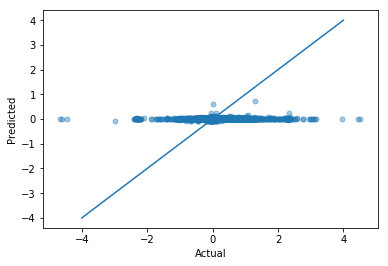

In [156]:
plt.plot(range(-4,5), range(-4,5))
plt.scatter(a.logerror, f, s=25, alpha=.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [157]:
y = b.drop(['logerror'], axis=1)
y = y[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']]


f = forest.predict(y)

s = forest.score(y, b[['logerror']])
s

0.002307643397235548

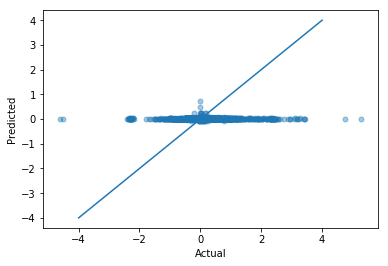

In [158]:
plt.plot(range(-4,5), range(-4,5))
plt.scatter(b.logerror, f, s=25, alpha=.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

##### Decent accuracy compared to other models, but it is a black box model. The whole point of trying to predict logerror is to identify what is driving logerror so that the Zestimate can be improved, and to do that we need to know how the model works.

Now what? What's the new plan?
1. Look at other regression models available to us.
1. Split the dataset into two sub-datasets. The first will be the properties where logerror is above zero, meaning the Zestimate overvalued the property.The other will be the properties where logerror is below zero, meaning the Zestimate undervalued the property.
1. Split dataset into two sub-datasets. The two subsets will be the outer extremes of logerror based on the logerror clusters.
1. Go back to prep and look at outliers.

### Other Regression Models
- Gradient Boosting
- Ada Boosting
- Elastic Net
- Lasso Regression

### Gradient Boosting

In [159]:
from sklearn.ensemble import GradientBoostingRegressor

train, test = explore_zillow.split_it(properties.drop(['cluster_target'], axis=1), training_size=.6)

gb = GradientBoostingRegressor(random_state=123)
gb.fit(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])
m = gb.predict(train.drop(['logerror', 'propertylandusedesc'], axis=1))

gb.score(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Parameters are df, train_size, random_state, and stratify
Returns train, test


0.0559018557129386

##### 5% accuracy. 

In [160]:
gb = GradientBoostingRegressor(random_state=123)
gb.fit(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
       train['logerror'])
m = gb.predict(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']])

gb.score(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
         train['logerror'])

0.0293285789138803

##### R2 score decreases to 3% when using the decision tree suggested variables.

### Ada Boosting

In [161]:
from sklearn.ensemble import AdaBoostRegressor

ab = AdaBoostRegressor(random_state=123)
ab.fit(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])
m = ab.predict(train.drop(['logerror', 'propertylandusedesc'], axis=1))

ab.score(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])

-0.9421871156379924

In [162]:
ab = AdaBoostRegressor(random_state=123)
ab.fit(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
       train['logerror'])
m = ab.predict(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']])

ab.score(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
         train['logerror'])

-0.5414030900863644

##### Not a good score. A better predictive model would be a horizontal line at the mean.

### Elastic Net

In [163]:
from sklearn.linear_model import ElasticNet

en = ElasticNet(random_state=123)
en.fit(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])
en.predict(train.drop(['logerror', 'propertylandusedesc'], axis=1))

en.score(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])

0.0032085031048815216

In [164]:
en = ElasticNet(random_state=123)
en.fit(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
       train['logerror'])
en.predict(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']])

en.score(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
         train['logerror'])

7.992967680292562e-05

##### Very disappointing results, especially with the decreased variables.

### Lasso Regression

In [165]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state=123)
lasso.fit(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])
lasso.predict(train.drop(['logerror', 'propertylandusedesc'], axis=1))

lasso.score(train.drop(['logerror', 'propertylandusedesc'], axis=1), train['logerror'])

0.003129157994083309

In [166]:
lasso = Lasso(random_state=123)
lasso.fit(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
       train['logerror'])
lasso.predict(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']])

lasso.score(train[['yearbuilt', 'cluster_lat_lon', 'cluster_loc_size', 'taxamount', 'lotsizesquarefeet']], 
         train['logerror'])

7.935180563978239e-05

##### Once again, disappointing.
All the models we wanted to run through have been completed. The best was gradient boosting, followed by random forest regression. Before moving on to splitting the dataset into subsets based on logerror, is there anything we can do with those two algorithms to better improve them?

- test different variables
- look further into the algorithms and parameters to see if I can adjust them to perform better

In [167]:
train.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
regionidcounty                   object
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxamount                       float64
logerror                        float64
propertylandusedesc              object
cluster_lat_lon                   int32
cluster_square_feet               int32
cluster_loc_size                  int32
la_county                         int64
orange_county                     int64
ventura_county                    int64
condo                             int64
single_family_residential         int64
dtype: object

In [168]:
X = train[['yearbuilt', 'taxamount', 'cluster_lat_lon', 'single_family_residential', 'condo', 'orange_county', 
           'poolcnt']]
y = train[['logerror']]

explore_zillow.gb_rf_regressions(X, y)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.027466822537357882
gradient boost mse is: 0.0243892703743286


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)


random forest regression r2 score is: 0.0034300629438120955
random forest regression mse is: 0.02499206629146043
Gradient Boosting performed better.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=123, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [169]:
lm = LinearRegression()
selector = RFE(lm, 5)
selector = selector.fit(train.drop(['logerror', 'propertylandusedesc'], axis=1), train[['logerror']])
print(selector.support_)
print(selector.ranking_)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False  True False False  True False False False  True False False False
 False False False False False False False  True  True]
[ 3  1 10  4  1 15 14 13  1  9  8 12 11  2  5  6  7 16 17  1  1]


In [170]:
rankings = pd.DataFrame(list(zip(selector.ranking_, 
                                 train.drop(['logerror', 'propertylandusedesc'], axis=1).columns)), 
                        columns=['rank', 'variable'])
rankings.sort_values(by='rank').head()

,rank,variable
20,1,single_family_residential
1,1,bedroomcnt
19,1,condo
4,1,hashottuborspa
8,1,poolcnt


In [171]:
X = train[['single_family_residential', 'bedroomcnt', 'condo', 'hashottuborspa', 'poolcnt']]
y = train[['logerror']]

explore_zillow.linear_regression(X, y)

linear regression r2 score is: 0.0016547144493049837
linear regression mse is: 0.02503658863316003


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False), 0.02503658863316003)

In [172]:
gb = GradientBoostingRegressor(random_state=123)
selector = RFE(gb, 5)
selector = selector.fit(train.drop(['logerror', 'propertylandusedesc'], axis=1), train[['logerror']])
print(selector.support_)
print(selector.ranking_)

rankings = pd.DataFrame(list(zip(selector.ranking_, 
                                 train.drop(['logerror', 'propertylandusedesc'], axis=1).columns)), 
                        columns=['rank', 'variable'])
rankings.sort_values(by='rank').head()

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False  True False False  True  True False False False False  True
  True False False False False False False False False]
[ 7  4  1  8 10  1  1  2  5 11  3  1  1  6 14  9 15 16 17 13 12]


,rank,variable
2,1,calculatedfinishedsquarefeet
12,1,taxamount
5,1,latitude
6,1,longitude
11,1,structuretaxvaluedollarcnt


In [173]:
X = train[['calculatedfinishedsquarefeet', 'taxamount', 'latitude', 'longitude', 'structuretaxvaluedollarcnt']]
y = train[['logerror']]

explore_zillow.gradient_boosting_regression(X, y)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.05301990316338412
gradient boost mse is: 0.02374844802838955


(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=123, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 0.02374844802838955)

In [174]:
# rf = RandomForestRegressor(random_state=123)
# selector = RFE(rf, 5)
# selector = selector.fit(train.drop(['logerror', 'propertylandusedesc'], axis=1), train[['logerror']])
# print(selector.support_)
# print(selector.ranking_)

# rankings = pd.DataFrame(list(zip(selector.ranking_, 
#                                  train.drop(['logerror', 'propertylandusedesc'], axis=1).columns)), 
#                         columns=['rank', 'variable'])
# rankings.sort_values(by='rank').head()

In [175]:
X = train[['calculatedfinishedsquarefeet', 'taxamount', 'latitude', 'longitude', 'structuretaxvaluedollarcnt']]
y = train[['logerror']]

explore_zillow.random_forest_regression(X, y)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)


random forest regression r2 score is: 0.009344211914707912
random forest regression mse is: 0.024843750756702462


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
 0.024843750756702462)

In [176]:
explore_zillow.recursive_feature_elimination(train.drop(['logerror', 'propertylandusedesc'], axis=1), 
                                             train[['logerror']], 
                                             GradientBoostingRegressor(random_state=123), 
                                             n_features=7)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
10     1                     yearbuilt
2      1  calculatedfinishedsquarefeet
12     1                     taxamount
5      1                      latitude
6      1                     longitude
7      1             lotsizesquarefeet
11     1    structuretaxvaluedollarcnt


,rank,variable
10,1,yearbuilt
2,1,calculatedfinishedsquarefeet
12,1,taxamount
5,1,latitude
6,1,longitude
7,1,lotsizesquarefeet
11,1,structuretaxvaluedollarcnt
1,2,bedroomcnt
8,3,poolcnt
13,4,cluster_lat_lon


In [177]:
explore_zillow.recursive_feature_elimination(train.drop(['logerror', 'propertylandusedesc'], axis=1), 
                                             train[['logerror']], 
                                             LinearRegression(), 
                                             n_features=7)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                   variable
0      1                bathroomcnt
13     1            cluster_lat_lon
19     1                      condo
8      1                    poolcnt
20     1  single_family_residential
1      1                 bedroomcnt
4      1             hashottuborspa


,rank,variable
0,1,bathroomcnt
13,1,cluster_lat_lon
19,1,condo
8,1,poolcnt
20,1,single_family_residential
1,1,bedroomcnt
4,1,hashottuborspa
3,2,garagecarcnt
14,3,cluster_square_feet
15,4,cluster_loc_size


In [178]:
explore_zillow.linear_models(X, y)

linear regression r2 score is: 0.0031101432192407463
linear regression mse is: 0.025000089265731607


ridge regression r2 score is: 0.0031101432192406353
ridge regression mse is: 0.02500008926573161


elastic net regression r2 score is: 0.00308383616096064
elastic net regression mse is: 0.025000748996393776


lasso regression r2 score is: 0.0030049275700279043
lasso regression mse is: 0.025002727872799967


Linear regression was the best model.


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=123, solver='auto', tol=0.001),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=123, selection='cyclic', tol=0.0001, warm_start=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=123,
    selection='cyclic', tol=0.0001, warm_start=False))

### Moving on to splitting the dataset.
We will split the dataset into two smaller datasets, positive logerror and negative log error. The idea here is that whatever is causing the Zestimate to overvalue a property might be different from what causes it to undervalue a property.

In [179]:
positive_logerror = properties[properties.logerror > 0]
negative_logerror = properties[properties.logerror < 0]
print(positive_logerror.shape)
print(negative_logerror.shape)

(73373, 24)
(57622, 24)


In [180]:
positive_logerror.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
regionidcounty                   object
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxamount                       float64
logerror                        float64
propertylandusedesc              object
cluster_target                   object
cluster_lat_lon                   int32
cluster_square_feet               int32
cluster_loc_size                  int32
la_county                         int64
orange_county                     int64
ventura_county                    int64
condo                             int64
single_family_residential         int64
dtype: object

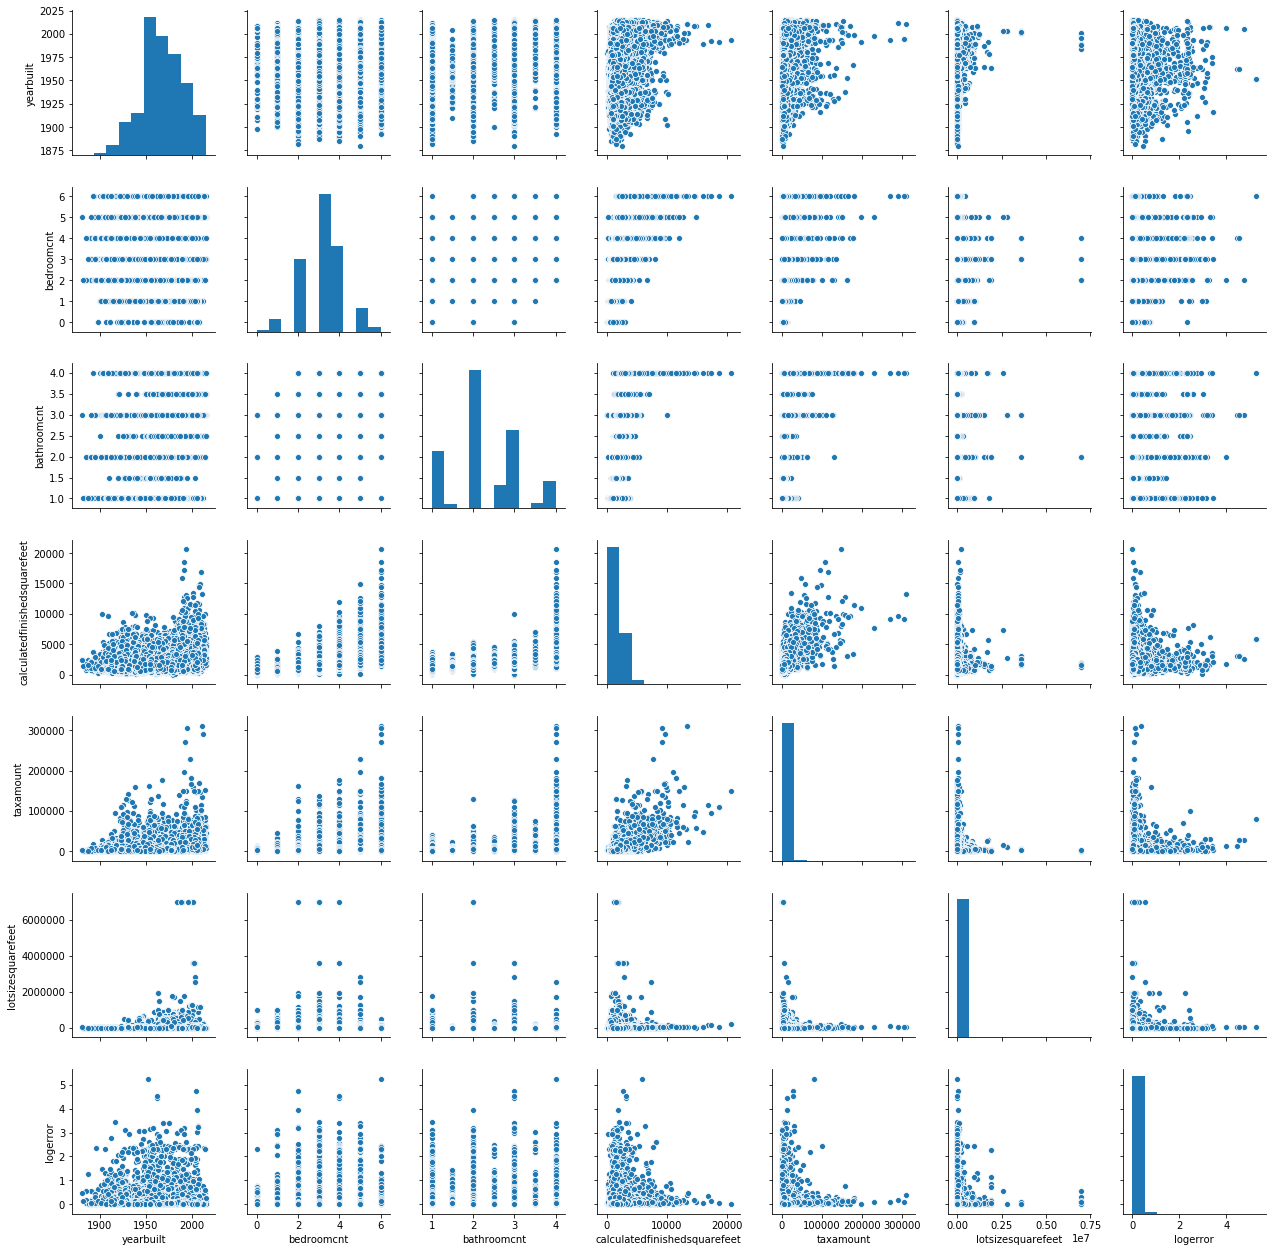

In [181]:
sns.pairplot(positive_logerror[['yearbuilt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 
                                'taxamount', 'lotsizesquarefeet', 'logerror']])

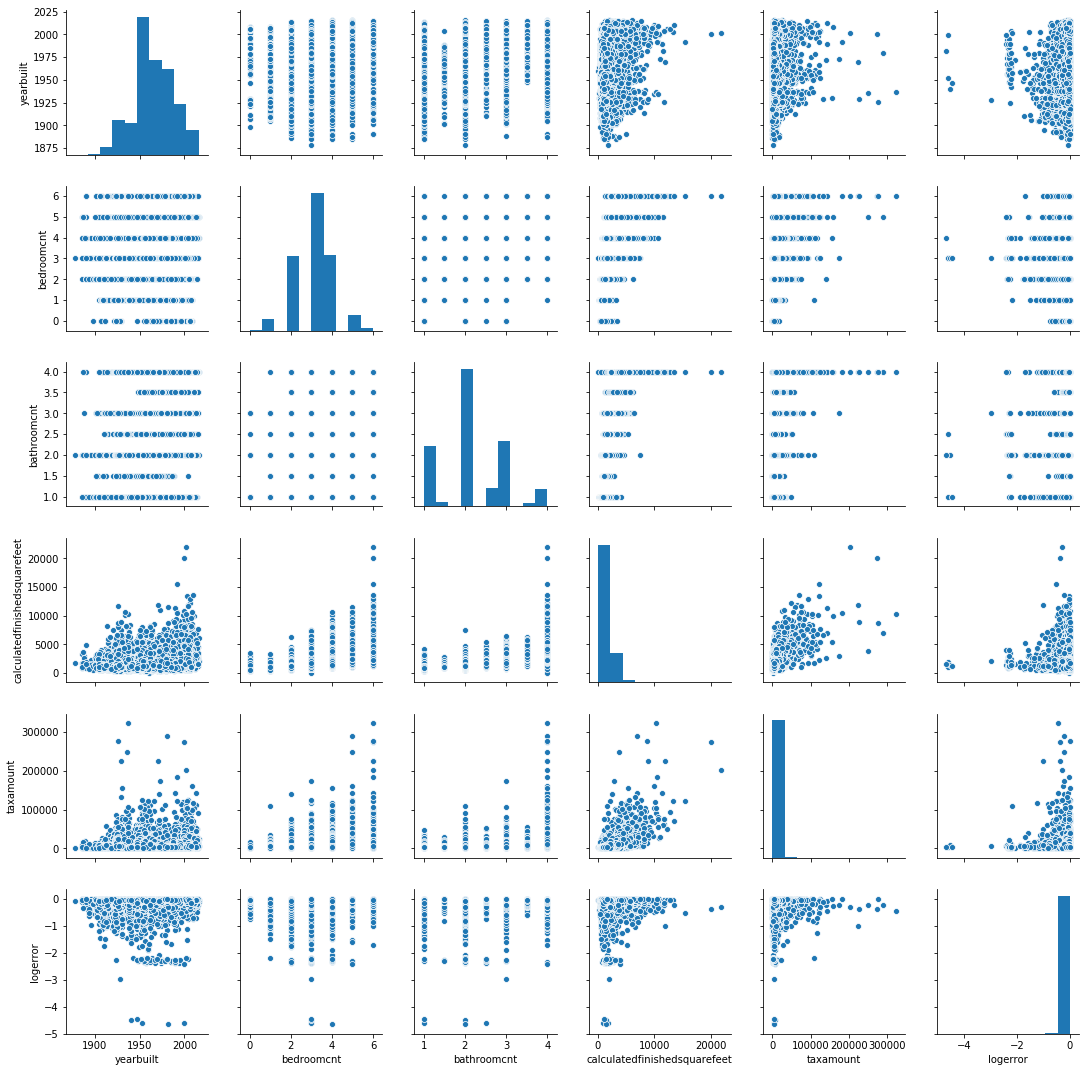

In [182]:
sns.pairplot(negative_logerror[['yearbuilt', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 
                                'taxamount', 'logerror']])

##### Still not seeing any correlations.

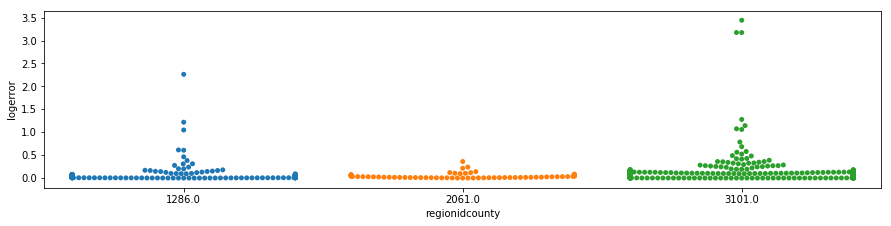

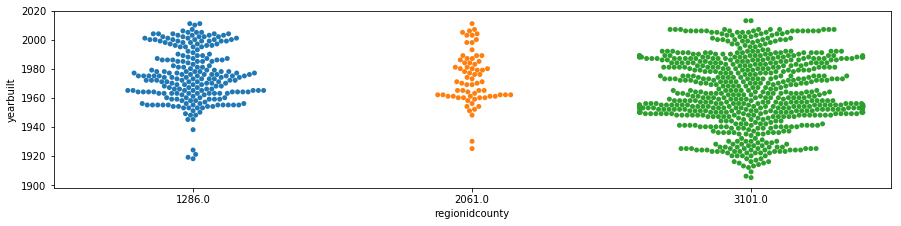

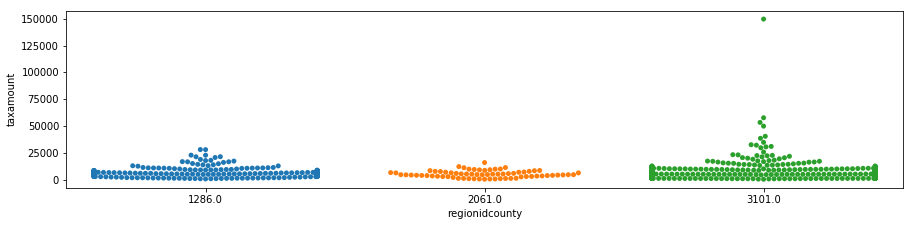

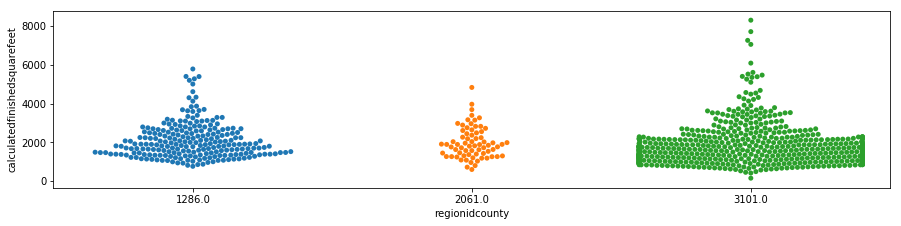

In [183]:
explore_zillow.swarm_subs(positive_logerror.sample(1000), 'regionidcounty', ['logerror', 'yearbuilt', 'taxamount', 
                                                                'calculatedfinishedsquarefeet'])

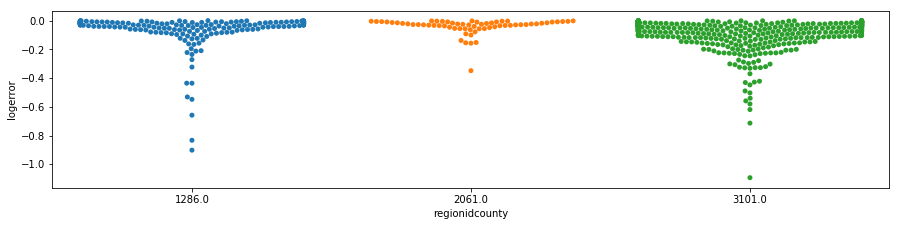

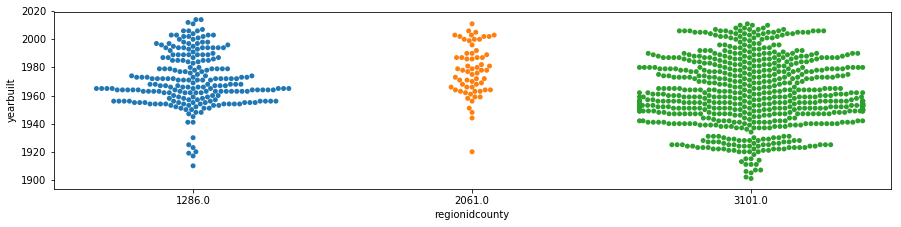

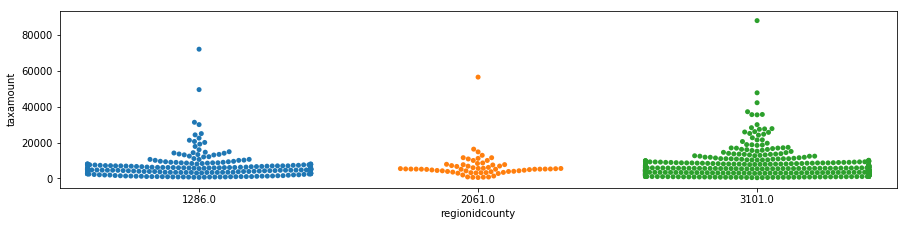

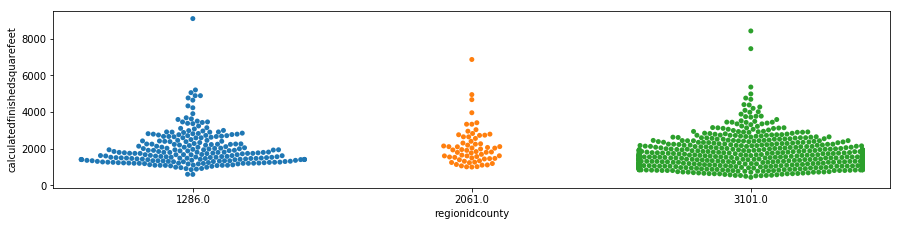

In [184]:
explore_zillow.swarm_subs(negative_logerror.sample(1000), 'regionidcounty', ['logerror', 'yearbuilt', 'taxamount', 
                                                                'calculatedfinishedsquarefeet'])

##### Model creation for the two datasets.
Positive logerror dataset first.

In [185]:
train_pos123, test_pos123 = explore_zillow.split_it(positive_logerror, training_size=.6)
train_neg123, test_neg123 = explore_zillow.split_it(negative_logerror, training_size=.6)

Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [186]:
X_pos = train_pos123.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_pos = train_pos123[['logerror']]

X_neg = train_neg123.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_neg = train_neg123[['logerror']]

In [187]:
# explore_zillow.recursive_feature_elimination(X_pos, y_pos, RandomForestRegressor(random_state=123), n_features=5)

In [188]:
explore_zillow.random_forest_regression(X_pos[['taxamount', 'structuretaxvaluedollarcnt', 'latitude', 
                                            'longitude', 'lotsizesquarefeet']], y_pos)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)


random forest regression r2 score is: 0.018530580617971304
random forest regression mse is: 0.024800053260603964


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
 0.024800053260603964)

In [189]:
explore_zillow.recursive_feature_elimination(X_pos, y_pos, GradientBoostingRegressor(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
10     1                     yearbuilt
2      1  calculatedfinishedsquarefeet
5      1                      latitude
11     1    structuretaxvaluedollarcnt
12     1                     taxamount


,rank,variable
10,1,yearbuilt
2,1,calculatedfinishedsquarefeet
5,1,latitude
11,1,structuretaxvaluedollarcnt
12,1,taxamount
6,2,longitude
7,3,lotsizesquarefeet
13,4,cluster_lat_lon
1,5,bedroomcnt
3,6,garagecarcnt


In [190]:
explore_zillow.gradient_boosting_regression(X_pos[['yearbuilt', 'calculatedfinishedsquarefeet', 'latitude', 
                                                    'structuretaxvaluedollarcnt', 'longitude']], y_pos)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.09283090258551496
gradient boost mse is: 0.022922611227580342


(GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=123, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 0.022922611227580342)

In [191]:
explore_zillow.recursive_feature_elimination(X_pos, y_pos, LinearRegression(), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                   variable
20     1  single_family_residential
16     1                  la_county
4      1             hashottuborspa
14     1        cluster_square_feet
19     1                      condo


,rank,variable
20,1,single_family_residential
16,1,la_county
4,1,hashottuborspa
14,1,cluster_square_feet
19,1,condo
3,2,garagecarcnt
13,3,cluster_lat_lon
8,4,poolcnt
15,5,cluster_loc_size
0,6,bathroomcnt


In [192]:
explore_zillow.linear_regression(X_pos[['single_family_residential', 'la_county', 'hashottuborspa', 'cluster_square_feet', 'condo']], y_pos)

linear regression r2 score is: 0.004554681146379136
linear regression mse is: 0.02515320033214346


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False), 0.02515320033214346)

In [193]:
explore_zillow.recursive_feature_elimination(X_pos, y_pos, Lasso(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
2      1  calculatedfinishedsquarefeet
7      1             lotsizesquarefeet
9      1                regionidcounty
11     1    structuretaxvaluedollarcnt
12     1                     taxamount


,rank,variable
2,1,calculatedfinishedsquarefeet
7,1,lotsizesquarefeet
9,1,regionidcounty
11,1,structuretaxvaluedollarcnt
12,1,taxamount
5,2,latitude
6,3,longitude
18,4,ventura_county
17,5,orange_county
16,6,la_county


In [194]:
explore_zillow.lasso_regression(X_pos[['calculatedfinishedsquarefeet', 'regionidcounty', 'structuretaxvaluedollarcnt', 'latitude', 'longitude']], y_pos)

lasso regression r2 score is: 0.0024315134402480565
lasso regression mse is: 0.025206849148044823


(Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=123,
    selection='cyclic', tol=0.0001, warm_start=False), 0.025206849148044823)

##### Not really seeing any improvements.
Moving on to negative logerror dataset.

In [195]:
# explore_zillow.recursive_feature_elimination(X_neg, y_neg, RandomForestRegressor(random_state=123), n_features=5)

In [196]:
explore_zillow.random_forest_regression(X_neg[['taxamount', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt']], y_neg)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)


random forest regression r2 score is: 0.02818747435165003
random forest regression mse is: 0.0165927728444889


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
 0.0165927728444889)

##### A better MSE for the negative logerrors than for the positive logerrors.

In [197]:
explore_zillow.recursive_feature_elimination(X_neg, y_neg, GradientBoostingRegressor(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                    variable
10     1                   yearbuilt
5      1                    latitude
6      1                   longitude
11     1  structuretaxvaluedollarcnt
12     1                   taxamount


,rank,variable
10,1,yearbuilt
5,1,latitude
6,1,longitude
11,1,structuretaxvaluedollarcnt
12,1,taxamount
7,2,lotsizesquarefeet
2,3,calculatedfinishedsquarefeet
13,4,cluster_lat_lon
1,5,bedroomcnt
15,6,cluster_loc_size


In [198]:
gb, mse_gb = explore_zillow.gradient_boosting_regression(X_neg[['yearbuilt', 'latitude', 'longitude', 
                                                                'taxamount', 'lotsizesquarefeet']], y_neg)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.14249733333592107
gradient boost mse is: 0.014641040927115063


##### An even lower MSE is calculated when using Gradient Boosting on the negative logerror dataset.
R2 is 0.14, high compared to all the others.

In [199]:
explore_zillow.recursive_feature_elimination(X_neg, y_neg, LinearRegression(), n_features=5)

    rank         variable
1      1       bedroomcnt
16     1        la_county
4      1   hashottuborspa
13     1  cluster_lat_lon
19     1            condo


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,rank,variable
1,1,bedroomcnt
16,1,la_county
4,1,hashottuborspa
13,1,cluster_lat_lon
19,1,condo
8,2,poolcnt
14,3,cluster_square_feet
15,4,cluster_loc_size
20,5,single_family_residential
3,6,garagecarcnt


In [200]:
explore_zillow.linear_regression(X_neg[['bedroomcnt', 'la_county', 'hashottuborspa', 'cluster_lat_lon', 'condo']], y_neg)

linear regression r2 score is: 0.010437045086647112
linear regression mse is: 0.016895844509972804


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False), 0.016895844509972804)

##### Linear regression also improves. It seems that it is slightly easier to find relationships between variables and negative logerror.

In [201]:
explore_zillow.recursive_feature_elimination(X_neg, y_neg, Ridge(random_state=123), n_features=5)

    rank         variable
1      1       bedroomcnt
16     1        la_county
4      1   hashottuborspa
13     1  cluster_lat_lon
19     1            condo


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,rank,variable
1,1,bedroomcnt
16,1,la_county
4,1,hashottuborspa
13,1,cluster_lat_lon
19,1,condo
8,2,poolcnt
14,3,cluster_square_feet
15,4,cluster_loc_size
3,5,garagecarcnt
0,6,bathroomcnt


Suggests same variables as linear regression.

In [202]:
explore_zillow.linear_models(X_neg[['bedroomcnt', 'la_county', 'hashottuborspa', 'cluster_lat_lon', 'condo']], y_neg)

linear regression r2 score is: 0.010437045086647112
linear regression mse is: 0.016895844509972804


ridge regression r2 score is: 0.010437044199011591
ridge regression mse is: 0.016895844525128333


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.017074047109465834


lasso regression r2 score is: 0.0
lasso regression mse is: 0.017074047109465834


Linear regression was the best model.


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=123, solver='auto', tol=0.001),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=123, selection='cyclic', tol=0.0001, warm_start=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=123,
    selection='cyclic', tol=0.0001, warm_start=False))

##### Of the linear models, Linear Regression proved the best.
I notice that feature selection doesn't like to use the variables with large numbers. Perhaps it is time to scale.

In [203]:
train_pos123.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
garagecarcnt                    float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
regionidcounty                   object
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxamount                       float64
logerror                        float64
propertylandusedesc              object
cluster_target                   object
cluster_lat_lon                   int32
cluster_square_feet               int32
cluster_loc_size                  int32
la_county                         int64
orange_county                     int64
ventura_county                    int64
condo                             int64
single_family_residential         int64
dtype: object

In [204]:
train_pos, scaler_pos = explore_zillow.min_max(train_pos123, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_neg, scaler_neg = explore_zillow.min_max(train_neg123, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])

X_pos = train_pos.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_pos = train_pos[['logerror']]

X_neg = train_neg.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_neg = train_neg[['logerror']]

/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


##### Sticking with linear models first since they are explainable.

In [205]:
explore_zillow.recursive_feature_elimination(X_pos, y_pos, LinearRegression(), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
10     1                     yearbuilt
19     1                         condo
7      1             lotsizesquarefeet
20     1     single_family_residential
2      1  calculatedfinishedsquarefeet


,rank,variable
10,1,yearbuilt
19,1,condo
7,1,lotsizesquarefeet
20,1,single_family_residential
2,1,calculatedfinishedsquarefeet
6,2,longitude
13,3,cluster_lat_lon
11,4,structuretaxvaluedollarcnt
0,5,bathroomcnt
4,6,hashottuborspa


In [206]:
explore_zillow.recursive_feature_elimination(X_pos, y_pos, Ridge(random_state=123), n_features=5)

    rank                      variable
10     1                     yearbuilt
19     1                         condo
7      1             lotsizesquarefeet
20     1     single_family_residential
2      1  calculatedfinishedsquarefeet


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,rank,variable
10,1,yearbuilt
19,1,condo
7,1,lotsizesquarefeet
20,1,single_family_residential
2,1,calculatedfinishedsquarefeet
6,2,longitude
13,3,cluster_lat_lon
11,4,structuretaxvaluedollarcnt
0,5,bathroomcnt
4,6,hashottuborspa


In [207]:
explore_zillow.recursive_feature_elimination(X_pos, y_pos, Lasso(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                   variable
20     1  single_family_residential
18     1             ventura_county
17     1              orange_county
9      1             regionidcounty
19     1                      condo


,rank,variable
20,1,single_family_residential
18,1,ventura_county
17,1,orange_county
9,1,regionidcounty
19,1,condo
16,2,la_county
15,3,cluster_loc_size
14,4,cluster_square_feet
13,5,cluster_lat_lon
12,6,taxamount


In [208]:
explore_zillow.linear_regression(X_pos[['yearbuilt', 'lotsizesquarefeet', 'single_family_residential', 
                                        'longitude', 'condo']], y_pos)

linear regression r2 score is: 0.007127755066194452
linear regression mse is: 0.02508818315586193


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False), 0.02508818315586193)

In [209]:
explore_zillow.linear_models(X_pos[['yearbuilt', 'lotsizesquarefeet', 'single_family_residential', 
                                        'longitude', 'condo']], y_pos)

linear regression r2 score is: 0.007127755066194452
linear regression mse is: 0.02508818315586193


ridge regression r2 score is: 0.0071258950220068895
ridge regression mse is: 0.025088230155996632


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.025268289333170504


lasso regression r2 score is: 0.0
lasso regression mse is: 0.025268289333170504


Linear regression was the best model.


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=123, solver='auto', tol=0.001),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=123, selection='cyclic', tol=0.0001, warm_start=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=123,
    selection='cyclic', tol=0.0001, warm_start=False))

In [210]:
explore_zillow.recursive_feature_elimination(X_neg, y_neg, LinearRegression(), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
10     1                     yearbuilt
2      1  calculatedfinishedsquarefeet
12     1                     taxamount
7      1             lotsizesquarefeet
6      1                     longitude


,rank,variable
10,1,yearbuilt
2,1,calculatedfinishedsquarefeet
12,1,taxamount
7,1,lotsizesquarefeet
6,1,longitude
11,2,structuretaxvaluedollarcnt
13,3,cluster_lat_lon
20,4,single_family_residential
19,5,condo
5,6,latitude


In [211]:
explore_zillow.linear_models(X_neg[['yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'longitude', 
                                    'single_family_residential']], y_neg)

linear regression r2 score is: 0.026370747853094123
linear regression mse is: 0.01662379171831026


ridge regression r2 score is: 0.02635210382077602
ridge regression mse is: 0.01662411004739637


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.017074047109465834


lasso regression r2 score is: 0.0
lasso regression mse is: 0.017074047109465834


Linear regression was the best model.


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=123, solver='auto', tol=0.001),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=123, selection='cyclic', tol=0.0001, warm_start=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=123,
    selection='cyclic', tol=0.0001, warm_start=False))

Negative logerrors are still better predicted than positive. 

### Now will group based on logerror cluster.

In [212]:
properties.cluster_target.unique()

array(['1', '2', '3', '4', '5'], dtype=object)

In [213]:
cluster_1 = properties[properties.cluster_target == '1']
cluster_2 = properties[properties.cluster_target == '2']
cluster_3 = properties[properties.cluster_target == '3']
cluster_4 = properties[properties.cluster_target == '4']
cluster_5 = properties[properties.cluster_target == '5']

print(cluster_1.shape)
print(cluster_2.shape)
print(cluster_3.shape)
print(cluster_4.shape)
print(cluster_5.shape)

(108917, 24)
(16644, 24)
(5354, 24)
(411, 24)
(307, 24)


In [214]:
train_1, test_1 = explore_zillow.split_it(cluster_1, training_size=.6)
train_2, test_2 = explore_zillow.split_it(cluster_2, training_size=.6)
train_3, test_3 = explore_zillow.split_it(cluster_3, training_size=.8)
train_4, test_4 = explore_zillow.split_it(cluster_4, training_size=.8)
train_5, test_5 = explore_zillow.split_it(cluster_5, training_size=.8)

train_1, scaler_1 = explore_zillow.min_max(train_1, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_2, scaler_2 = explore_zillow.min_max(train_2, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_3, scaler_3 = explore_zillow.min_max(train_3, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_4, scaler_4 = explore_zillow.min_max(train_4, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_5, scaler_5 = explore_zillow.min_max(train_5, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])

X_1 = train_1.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_1 = train_1[['logerror']]

X_2 = train_2.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_2 = train_2[['logerror']]

X_3 = train_3.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_3 = train_3[['logerror']]

X_4 = train_4.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_4 = train_4[['logerror']]

X_5 = train_5.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_5 = train_5[['logerror']]

Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


In [215]:
X_1.shape

(65350, 21)

In [216]:
train_1.shape

(65350, 24)

In [217]:
test_1[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxamount']] = scaler_1.transform(test_1[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 
                            'lotsizesquarefeet', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxamount']])
test_2[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 
       'structuretaxvaluedollarcnt', 'taxamount']] = scaler_2.transform(test_2[['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount']])
test_3[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 
       'structuretaxvaluedollarcnt', 'taxamount']] = scaler_3.transform(test_3[['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount']])
test_4[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 
       'structuretaxvaluedollarcnt', 'taxamount']] = scaler_4.transform(test_4[['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount']])
test_5[['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 'yearbuilt', 
       'structuretaxvaluedollarcnt', 'taxamount']] = scaler_5.transform(test_5[['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount']])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [218]:
explore_zillow.recursive_feature_elimination(X_1, y_1, LinearRegression(), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
10     1                     yearbuilt
12     1                     taxamount
11     1    structuretaxvaluedollarcnt
20     1     single_family_residential
2      1  calculatedfinishedsquarefeet


,rank,variable
10,1,yearbuilt
12,1,taxamount
11,1,structuretaxvaluedollarcnt
20,1,single_family_residential
2,1,calculatedfinishedsquarefeet
19,2,condo
7,3,lotsizesquarefeet
8,4,poolcnt
4,5,hashottuborspa
5,6,latitude


In [219]:
lm1, ridge1, en1, lasso1 = explore_zillow.linear_models(X_neg[['yearbuilt', 'calculatedfinishedsquarefeet', 
                                                               'taxamount', 
                                                               'structuretaxvaluedollarcnt', 
                                                               'single_family_residential']], y_neg)

linear regression r2 score is: 0.0257769272497973
linear regression mse is: 0.016633930639265524


ridge regression r2 score is: 0.02574071967909397
ridge regression mse is: 0.01663454884903343


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.017074047109465834


lasso regression r2 score is: 0.0
lasso regression mse is: 0.017074047109465834


Linear regression was the best model.


In [220]:
explore_zillow.recursive_feature_elimination(X_2, y_2, LinearRegression(), n_features=5)

    rank                      variable
10     1                     yearbuilt
2      1  calculatedfinishedsquarefeet
6      1                     longitude
7      1             lotsizesquarefeet
12     1                     taxamount


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,rank,variable
10,1,yearbuilt
2,1,calculatedfinishedsquarefeet
6,1,longitude
7,1,lotsizesquarefeet
12,1,taxamount
5,2,latitude
13,3,cluster_lat_lon
4,4,hashottuborspa
11,5,structuretaxvaluedollarcnt
1,6,bedroomcnt


In [221]:
lm2, ridge2, en2, lasso2 = explore_zillow.linear_models(X_neg[['yearbuilt', 'calculatedfinishedsquarefeet', 
                                                               'taxamount', 'longitude', 'latitude']], y_neg)

linear regression r2 score is: 0.02593623538728418
linear regression mse is: 0.01663121060462115


ridge regression r2 score is: 0.02591272333856831
ridge regression mse is: 0.016631612050448566


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.017074047109465834


lasso regression r2 score is: 0.0
lasso regression mse is: 0.017074047109465834


Linear regression was the best model.


In [222]:
explore_zillow.recursive_feature_elimination(X_3, y_3, LinearRegression(), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
20     1     single_family_residential
19     1                         condo
2      1  calculatedfinishedsquarefeet
7      1             lotsizesquarefeet
4      1                hashottuborspa


,rank,variable
20,1,single_family_residential
19,1,condo
2,1,calculatedfinishedsquarefeet
7,1,lotsizesquarefeet
4,1,hashottuborspa
5,2,latitude
10,3,yearbuilt
12,4,taxamount
16,5,la_county
6,6,longitude


In [223]:
lm3, ridge3, en3, lasso3 = explore_zillow.linear_models(X_neg[['condo', 'calculatedfinishedsquarefeet', 
                                                               'hashottuborspa', 'latitude', 
                                                               'single_family_residential']], y_neg)

linear regression r2 score is: 0.0017317907811752464
linear regression mse is: 0.01704447843208431


ridge regression r2 score is: 0.0017315673687533506
ridge regression mse is: 0.017044482246638525


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.017074047109465834


lasso regression r2 score is: 0.0
lasso regression mse is: 0.017074047109465834


Linear regression was the best model.


In [224]:
explore_zillow.recursive_feature_elimination(X_4, y_4, LinearRegression(), n_features=5)

    rank                      variable
10     1                     yearbuilt
16     1                     la_county
2      1  calculatedfinishedsquarefeet
12     1                     taxamount
11     1    structuretaxvaluedollarcnt


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,rank,variable
10,1,yearbuilt
16,1,la_county
2,1,calculatedfinishedsquarefeet
12,1,taxamount
11,1,structuretaxvaluedollarcnt
7,2,lotsizesquarefeet
5,3,latitude
19,4,condo
8,5,poolcnt
6,6,longitude


In [225]:
lm4, ridge4, en4, lasso4 = explore_zillow.linear_models(X_neg[['yearbuilt', 'calculatedfinishedsquarefeet', 
                                                               'taxamount', 'la_county', 'latitude']], y_neg)

linear regression r2 score is: 0.0260824771545759
linear regression mse is: 0.01662871366579704


ridge regression r2 score is: 0.026060235274988464
ridge regression mse is: 0.016629093424696918


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.017074047109465834


lasso regression r2 score is: 0.0
lasso regression mse is: 0.017074047109465834


Linear regression was the best model.


In [226]:
explore_zillow.recursive_feature_elimination(X_5, y_5, LinearRegression(), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                    variable
10     1                   yearbuilt
5      1                    latitude
6      1                   longitude
12     1                   taxamount
11     1  structuretaxvaluedollarcnt


,rank,variable
10,1,yearbuilt
5,1,latitude
6,1,longitude
12,1,taxamount
11,1,structuretaxvaluedollarcnt
2,2,calculatedfinishedsquarefeet
16,3,la_county
7,4,lotsizesquarefeet
13,5,cluster_lat_lon
14,6,cluster_square_feet


In [227]:
lm5, ridge5, en5, lasso5 = explore_zillow.linear_models(X_neg[['yearbuilt', 'latitude', 'longitude', 'taxamount', 
                                                               'calculatedfinishedsquarefeet']], y_neg)

linear regression r2 score is: 0.02593623538728418
linear regression mse is: 0.01663121060462115


ridge regression r2 score is: 0.02591272333856831
ridge regression mse is: 0.016631612050448566


elastic net regression r2 score is: 0.0
elastic net regression mse is: 0.017074047109465834


lasso regression r2 score is: 0.0
lasso regression mse is: 0.017074047109465834


Linear regression was the best model.


### Of all the models looked at, Gradient Boosting was the best. It had the lowest MSE of 0.015 and the highest R2 of 0.14. If not including the black box models, the best predictions were made after grouping the logerrors into clusters. MSE's were around 0.016 and 0.017 and r2's were around 2.6% except for cluster 3, which was under 1%
We will test our GB model on the out-of-sample data and see how it performs.

In [228]:
X_neg = test_neg123.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_neg = test_neg123[['logerror']]

y_pred = gb.predict(X_neg[['yearbuilt', 'latitude', 'longitude', 'taxamount', 'lotsizesquarefeet']])
r2 = gb.score(X_neg[['yearbuilt', 'latitude', 'longitude', 'taxamount', 'lotsizesquarefeet']], y_neg)
mse = mean_squared_error(y_neg, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')

r2: 0.03745190003495669
mse: 0.012827753746387446


Linear regression on clustered logerror groups.

In [229]:
X_1 = test_1.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_1 = test_1[['logerror']]

X_2 = test_2.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_2 = test_2[['logerror']]

X_3 = test_3.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_3 = test_3[['logerror']]

X_4 = test_4.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_4 = test_4[['logerror']]

X_5 = test_5.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_5 = test_5[['logerror']]

In [230]:
p = lm1.predict(X_1[['yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'structuretaxvaluedollarcnt', 
                       'single_family_residential']])
r2 = r2_score(y_1, p)
mse = mean_squared_error(y_1, p)
print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -3.4480233812359264
mse: 0.009351834635669375


In [231]:
p = lm2.predict(X_2[['yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'longitude', 'latitude']])
r2 = r2_score(y_2, p)
mse = mean_squared_error(y_2, p)
print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -0.4446226374876403
mse: 0.011594387585429586


In [232]:
p = lm3.predict(X_3[['condo', 'calculatedfinishedsquarefeet', 'hashottuborspa', 'latitude', 
                       'single_family_residential']])
r2 = r2_score(y_3, p)
mse = mean_squared_error(y_3, p)
print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -4.96215799916617
mse: 0.2175225903726129


In [233]:
p = lm4.predict(X_4[['yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'la_county', 'latitude']])
r2 = r2_score(y_4, p)
mse = mean_squared_error(y_4, p)
print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -1.7234367207668693
mse: 2.001220867739437


In [234]:
p = lm5.predict(X_5[['yearbuilt', 'latitude', 'longitude', 'taxamount', 'calculatedfinishedsquarefeet']])
r2 = r2_score(y_5, p)
mse = mean_squared_error(y_5, p)
print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -7.365452900458873
mse: 5.381927110975861


### Gradient Boosting model r2 decreased to 0.037, but MSE also decreased to 0.013. Linear regression after clustering resulted in negative r2's and higher MSE's.
Perhaps these models can be improved by adding more features or changing the max depth for GB. Using GB with the clustering of logerror might help. However, this is is all that can be done in the time given.

### Trying out GB with cluster groups.

In [235]:
train_1, test_1 = explore_zillow.split_it(cluster_1, training_size=.6)
train_2, test_2 = explore_zillow.split_it(cluster_2, training_size=.6)
train_3, test_3 = explore_zillow.split_it(cluster_3, training_size=.8)
train_4, test_4 = explore_zillow.split_it(cluster_4, training_size=.8)
train_5, test_5 = explore_zillow.split_it(cluster_5, training_size=.8)

train_1, scaler_1 = explore_zillow.min_max(train_1, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_2, scaler_2 = explore_zillow.min_max(train_2, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_3, scaler_3 = explore_zillow.min_max(train_3, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_4, scaler_4 = explore_zillow.min_max(train_4, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])
train_5, scaler_5 = explore_zillow.min_max(train_5, ['calculatedfinishedsquarefeet', 'latitude', 
                                                           'longitude', 'lotsizesquarefeet', 'yearbuilt' , 
                                                           'structuretaxvaluedollarcnt', 'taxamount'])

X_1 = train_1.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_1 = train_1[['logerror']]

X_2 = train_2.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_2 = train_2[['logerror']]

X_3 = train_3.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_3 = train_3[['logerror']]

X_4 = train_4.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_4 = train_4[['logerror']]

X_5 = train_5.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_5 = train_5[['logerror']]

Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test
Parameters are df, train_size, random_state, and stratify
Returns train, test


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/Users/MatthewZapata/ds-methodologies-exercises/clustering/explore_zillow.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train[list_of_what_to_standardize] = scaler.transform(train[list_of_what_to_standardize])


Parameters are a training df and a list of what columns to standardize.
Returns the normalized training df and the scaler for scaling the test set.


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [236]:
explore_zillow.recursive_feature_elimination(X_1, y_1, GradientBoostingRegressor(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
10     1                     yearbuilt
12     1                     taxamount
2      1  calculatedfinishedsquarefeet
7      1             lotsizesquarefeet
5      1                      latitude


,rank,variable
10,1,yearbuilt
12,1,taxamount
2,1,calculatedfinishedsquarefeet
7,1,lotsizesquarefeet
5,1,latitude
6,2,longitude
11,3,structuretaxvaluedollarcnt
0,4,bathroomcnt
8,5,poolcnt
1,6,bedroomcnt


In [237]:
gb_1, mse_1 = explore_zillow.gradient_boosting_regression(X_1[['yearbuilt', 'taxamount', 
                                                               'calculatedfinishedsquarefeet', 'latitude', 
                                                               'longitude']], y_1)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.04757432564943209
gradient boost mse is: 0.0019597294798963834


In [238]:
explore_zillow.recursive_feature_elimination(X_2, y_2, GradientBoostingRegressor(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                    variable
10     1                   yearbuilt
5      1                    latitude
7      1           lotsizesquarefeet
12     1                   taxamount
11     1  structuretaxvaluedollarcnt


,rank,variable
10,1,yearbuilt
5,1,latitude
7,1,lotsizesquarefeet
12,1,taxamount
11,1,structuretaxvaluedollarcnt
6,2,longitude
2,3,calculatedfinishedsquarefeet
15,4,cluster_loc_size
3,5,garagecarcnt
1,6,bedroomcnt


In [239]:
gb_2, mse_2 = explore_zillow.gradient_boosting_regression(X_2[['yearbuilt', 'latitude', 'lotsizesquarefeet', 
                                                               'taxamount', 'longitude']], y_2)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.14992142712558187
gradient boost mse is: 0.006797590300823183


In [240]:
explore_zillow.recursive_feature_elimination(X_3, y_3, GradientBoostingRegressor(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                    variable
5      1                    latitude
6      1                   longitude
7      1           lotsizesquarefeet
12     1                   taxamount
11     1  structuretaxvaluedollarcnt


,rank,variable
5,1,latitude
6,1,longitude
7,1,lotsizesquarefeet
12,1,taxamount
11,1,structuretaxvaluedollarcnt
2,2,calculatedfinishedsquarefeet
10,3,yearbuilt
1,4,bedroomcnt
3,5,garagecarcnt
19,6,condo


In [241]:
gb_3, mse_3 = explore_zillow.gradient_boosting_regression(X_3[['latitude', 'longitude', 'lotsizesquarefeet', 
                                                               'taxamount', 'yearbuilt']], y_3)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.13143182364547445
gradient boost mse is: 0.029984721478903943


In [242]:
explore_zillow.recursive_feature_elimination(X_4, y_4, GradientBoostingRegressor(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank   variable
10     1  yearbuilt
16     1  la_county
12     1  taxamount
5      1   latitude
6      1  longitude


,rank,variable
10,1,yearbuilt
16,1,la_county
12,1,taxamount
5,1,latitude
6,1,longitude
7,2,lotsizesquarefeet
9,3,regionidcounty
8,4,poolcnt
15,5,cluster_loc_size
2,6,calculatedfinishedsquarefeet


In [243]:
gb_4, mse_4 = explore_zillow.gradient_boosting_regression(X_4[['yearbuilt', 'la_county', 'taxamount', 'latitude', 
                                                              'longitude']], y_4)

gradient boost r2 is: 0.8665102770581394
gradient boost mse is: 0.044926916038962886


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [244]:
explore_zillow.recursive_feature_elimination(X_5, y_5, GradientBoostingRegressor(random_state=123), n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                      variable
10     1                     yearbuilt
2      1  calculatedfinishedsquarefeet
12     1                     taxamount
5      1                      latitude
7      1             lotsizesquarefeet


,rank,variable
10,1,yearbuilt
2,1,calculatedfinishedsquarefeet
12,1,taxamount
5,1,latitude
7,1,lotsizesquarefeet
11,2,structuretaxvaluedollarcnt
6,3,longitude
1,4,bedroomcnt
14,5,cluster_square_feet
8,6,poolcnt


In [245]:
gb_5, mse_5 = explore_zillow.gradient_boosting_regression(X_5[['yearbuilt', 'calculatedfinishedsquarefeet', 
                                                               'taxamount', 'latitude', 'longitude']], y_5)

gradient boost r2 is: 0.7826449373626829
gradient boost mse is: 0.08522232666595325


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Decent R2's and MSE's when using GB on the training set.
Moving on to the test set.

In [246]:
X_1 = test_1.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_1 = test_1[['logerror']]

X_2 = test_2.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_2 = test_2[['logerror']]

X_3 = test_3.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_3 = test_3[['logerror']]

X_4 = test_4.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_4 = test_4[['logerror']]

X_5 = test_5.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_5 = test_5[['logerror']]

In [247]:
y_pred = gb_1.predict(X_1[['yearbuilt', 'taxamount', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']])
r2 = gb_1.score(X_1[['yearbuilt', 'taxamount', 'calculatedfinishedsquarefeet', 'latitude', 'longitude']], y_1)
mse = mean_squared_error(y_1, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -13.158398368766164
mse: 0.029767604372133855


In [248]:
y_pred = gb_2.predict(X_2[['yearbuilt', 'latitude', 'lotsizesquarefeet', 'taxamount', 'longitude']])
r2 = gb_2.score(X_2[['yearbuilt', 'latitude', 'lotsizesquarefeet', 'taxamount', 'longitude']], y_2)
mse = mean_squared_error(y_2, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -31.69261540899628
mse: 0.262387452887006


In [249]:
y_pred = gb_3.predict(X_3[['latitude', 'longitude', 'lotsizesquarefeet', 'taxamount', 'yearbuilt']])
r2 = gb_3.score(X_3[['latitude', 'longitude', 'lotsizesquarefeet', 'taxamount', 'yearbuilt']], y_3)
mse = mean_squared_error(y_3, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -2.595152143132471
mse: 0.13116505920627988


In [250]:
y_pred = gb_4.predict(X_4[['yearbuilt', 'la_county', 'taxamount', 'latitude', 'longitude']])
r2 = gb_4.score(X_4[['yearbuilt', 'la_county', 'taxamount', 'latitude', 'longitude']], y_4)
mse = mean_squared_error(y_4, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -1.3867582028493066
mse: 1.7538246016031374


In [251]:
y_pred = gb_5.predict(X_5[['yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'latitude', 'longitude']])
r2 = gb_5.score(X_5[['yearbuilt', 'calculatedfinishedsquarefeet', 'taxamount', 'latitude', 'longitude']], y_5)
mse = mean_squared_error(y_5, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -7.002565272628706
mse: 5.148462792223943


### Performance drops drastically. Perhaps due to overfitting or smaller datasets.
What about changing the number of features used with the original GB model?

In [252]:
X_pos = train_pos123.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_pos = train_pos123[['logerror']]

X_neg = train_neg123.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_neg = train_neg123[['logerror']]

In [253]:
explore_zillow.recursive_feature_elimination(X_neg, y_neg, GradientBoostingRegressor(random_state=123), 
                                             n_features=5)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    rank                    variable
10     1                   yearbuilt
5      1                    latitude
6      1                   longitude
12     1                   taxamount
11     1  structuretaxvaluedollarcnt


,rank,variable
10,1,yearbuilt
5,1,latitude
6,1,longitude
12,1,taxamount
11,1,structuretaxvaluedollarcnt
7,2,lotsizesquarefeet
2,3,calculatedfinishedsquarefeet
13,4,cluster_lat_lon
15,5,cluster_loc_size
1,6,bedroomcnt


In [254]:
gb, mse_gb = explore_zillow.gradient_boosting_regression(X_neg[['yearbuilt', 'latitude', 'longitude', 
                                                                'taxamount', 'lotsizesquarefeet']], y_neg)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gradient boost r2 is: 0.1415982358674901
gradient boost mse is: 0.014656392159647053


In [255]:
X_neg = test_neg123.drop(['logerror', 'propertylandusedesc', 'cluster_target'], axis=1)
y_neg = test_neg123[['logerror']]

y_pred = gb.predict(X_neg[['yearbuilt', 'latitude', 'longitude', 'taxamount', 'lotsizesquarefeet']])
r2 = gb.score(X_neg[['yearbuilt', 'latitude', 'longitude', 'taxamount', 'lotsizesquarefeet']], y_neg)
mse = mean_squared_error(y_neg, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')

r2: -23.383704516658778
mse: 0.32495846906324327


Why are these reults different from the results we were getting earlier?